In [43]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load data 
df = pd.read_csv('patient-data.csv')
df.head()

p01     p02    p03         p04       p05   p06    p07    p08    p09  \
0 123.268 178.595 16.400 410,204.101 8,834.625 4.810 42.033 92.319 27.005   
1  78.100 125.917 17.343 421,416.382 7,551.744 4.650 40.210 85.496 28.293   
2 102.281 133.735 15.710 267,971.238 6,030.085 4.624 46.894 85.234 32.409   
3  79.184 125.291 15.201 204,385.856 4,507.020 4.353 38.892 93.113 27.778   
4  82.117 187.165 17.453 384,908.487 7,096.110 4.696 50.804 88.335 28.600   

     p10  ...   p16     p17    p18    p19    p20    p21   p22   p23   p24  \
0 35.258  ... 5.042  81.518 49.968 11.828 28.273 97.398 0.649 0.019 2.892   
1 34.059  ... 5.800 109.089 41.420 40.000 20.125 85.017 1.023 0.034 1.499   
2 32.082  ... 4.965  92.358 48.048 10.000 25.097 74.378 0.863 0.033 2.929   
3 34.040  ... 4.000  70.448 56.575 18.282 27.764 65.041 0.911 0.026 1.321   
4 35.300  ... 4.885  77.147 43.833 10.260 26.937 92.952 0.688 0.033 0.341   

    Ailment  
0   Healthy  
1  Diabetes  
2  Thalasse  
3    Anemia  
4  Thalasse  

[5 rows x 25 columns]

In [44]:
# Q1(a): how many rows and columns?
r, c = df.shape
print("Rows:", r)
print("Columns:", c)

# Q1(b): how many rows and columns have missing data?
rows_with_na = df.isna().any(axis=1).sum()
cols_with_na = df.isna().any().sum()
print("Rows with missing:", rows_with_na)
print("Columns with missing:", cols_with_na)

Rows: 2371
Columns: 25
Rows with missing: 4
Columns with missing: 21


In [45]:
# Q2: Identify level of measurement for each column and assign one of:
# "nominal", "ordinal", "ratio", or "interval"

levels = {}  # Dictionary to store column name → measurement level

# Loop through each column in the dataframe
for col in df.columns:
    s = df[col]  # Extract the column as a pandas Series

    # -------------------------------
    # Step 1: Check for categorical (object/string) columns
    # -------------------------------
    if s.dtype == "O":  # "O" means object type (usually strings)
        levels[col] = "nominal"  # Categorical data → nominal scale
        continue  # Skip to next column

    # -------------------------------
    # Step 2: Remove missing values
    # -------------------------------
    x = s.dropna().values  # Drop NaN values for clean numeric checks
    if len(x) == 0:  # If the column becomes empty after removing NaNs
        levels[col] = "nominal"  # No valid numeric info → treat as nominal
        continue

    # -------------------------------
    # Step 3: Check if data is integer-like
    # -------------------------------
    # np.isclose() compares each value with its rounded version
    # np.all() ensures all values satisfy the condition
    is_int_like = np.all(np.isclose(x, np.round(x)))

    # -------------------------------
    # Step 4: Count distinct values
    # -------------------------------
    unique_count = len(np.unique(x))  # Fewer unique values may mean ordinal scale

    # -------------------------------
    # Step 5: Check if negative values exist
    # -------------------------------
    mn = float(np.min(x))  # Minimum value in the column

    # -------------------------------
    # Step 6: Decide measurement level
    # -------------------------------
    if is_int_like and unique_count <= 10:
        levels[col] = "ordinal"   # Integer-like, few categories → ordinal
    elif mn < 0:
        levels[col] = "interval"  # Can be negative → zero is arbitrary
    else:
        levels[col] = "ratio"     # Only positive → meaningful zero

# -------------------------------
# Step 7: Display results
# -------------------------------
for k, v in levels.items():
    print(f"{k}: {v}")


p01: ratio
p02: ratio
p03: ratio
p04: ratio
p05: ratio
p06: ratio
p07: ratio
p08: ratio
p09: ratio
p10: ratio
p11: ratio
p12: ratio
p13: ratio
p14: ratio
p15: ratio
p16: ratio
p17: ratio
p18: ratio
p19: ratio
p20: ratio
p21: ratio
p22: ratio
p23: ratio
p24: ratio
Ailment: nominal


In [46]:
# Q3: build and display descriptive tables
import numpy as np
import pandas as pd

# containers to collect summary rows for each measurement level
nom_rows, ord_rows, num_rows = [], [], []

# iterate over every column in the dataframe
for col in df.columns:
    s = df[col]                       # pandas Series for the column
    lvl = levels.get(col, "nominal")  # measurement level inferred earlier
    n = len(s)                        # total number of entries (including NaNs)
    miss_n = int(s.isna().sum())      # count of missing values
    # percentage missing (guard divide-by-zero although n>0 normally)
    miss_p = (miss_n / n * 100.0) if n else 0.0

    # --------------------------
    # NOMINAL: categorical columns
    # --------------------------
    if lvl == "nominal":
        vc = s.value_counts(dropna=True)  # category counts, ignore NaN
        if len(vc) > 0:
            mode_val = vc.index[0]          # most frequent category
            mode_n = int(vc.iloc[0])       # frequency of the mode
            denom = max(n - miss_n, 1)     # denominator = count of non-missing rows
            mode_p = mode_n / denom * 100.0
        else:
            # column has no non-missing values
            mode_val, mode_n, mode_p = None, 0, 0.0

        # append a dictionary (row) for this nominal column
        nom_rows.append({
            "column": col,
            "level": "nominal",
            "n": n,
            "missing_n": miss_n,
            "missing_%": round(miss_p, 2),
            "unique": int(s.nunique(dropna=True)),
            "mode": mode_val,
            "mode_n": mode_n,
            "mode_%": round(mode_p, 2)
        })
        continue  # go to next column

    # --------------------------
    # ORDINAL: ordered categories or small integer scales
    # --------------------------
    if lvl == "ordinal":
        if pd.api.types.is_numeric_dtype(s):
            # numeric ordinal → show distributional quantiles (order matters)
            ord_rows.append({
                "column": col,
                "level": "ordinal",
                "n": n,
                "missing_n": miss_n,
                "missing_%": round(miss_p, 2),
                "min": s.min(),
                "q1": s.quantile(0.25),
                "median": s.quantile(0.50),
                "q3": s.quantile(0.75),
                "max": s.max()
            })
        else:
            # non-numeric ordinal (e.g., "low","mid","high") → treat like nominal for mode
            vc = s.value_counts(dropna=True)
            if len(vc) > 0:
                mode_val = vc.index[0]
                mode_n = int(vc.iloc[0])
                denom = max(n - miss_n, 1)
                mode_p = mode_n / denom * 100.0
            else:
                mode_val, mode_n, mode_p = None, 0, 0.0

            ord_rows.append({
                "column": col,
                "level": "ordinal",
                "n": n,
                "missing_n": miss_n,
                "missing_%": round(miss_p, 2),
                "unique": int(s.nunique(dropna=True)),
                "mode": mode_val,
                "mode_n": mode_n,
                "mode_%": round(mode_p, 2)
            })
        continue  # next column

    # ---------------------------------------
    # RATIO or INTERVAL: numeric continuous data
    # ---------------------------------------
    if lvl in ("ratio", "interval"):
        desc = s.describe()                          # count, mean, std, min, 25/50/75, max
        q1, q3 = s.quantile(0.25), s.quantile(0.75)  # explicit Q1 & Q3 for IQR
        num_rows.append({
            "column": col,
            "level": lvl,
            "n": n,
            "missing_n": miss_n,
            "missing_%": round(miss_p, 2),
            "mean": desc.get("mean", np.nan),
            "std": desc.get("std", np.nan),
            "min": desc.get("min", np.nan),
            "q1": q1,
            "median": desc.get("50%", np.nan),
            "q3": q3,
            "max": desc.get("max", np.nan),
            "iqr": q3 - q1,
            "skew": s.skew(skipna=True)   # measure of asymmetry
        })
        continue  # next column

# convert collected rows into DataFrames for display
nominal_table = pd.DataFrame(nom_rows)
ordinal_table = pd.DataFrame(ord_rows)
numeric_table = pd.DataFrame(num_rows)

# sort tables (optional: show columns with largest missing% first)
if not nominal_table.empty and "missing_%" in nominal_table.columns:
    nominal_table = nominal_table.sort_values(["missing_%", "unique"], ascending=[False, True]).reset_index(drop=True)
if not ordinal_table.empty and "missing_%" in ordinal_table.columns:
    ordinal_table = ordinal_table.sort_values(["missing_%"], ascending=[False]).reset_index(drop=True)
if not numeric_table.empty and "missing_%" in numeric_table.columns:
    numeric_table = numeric_table.sort_values(["missing_%"], ascending=[False]).reset_index(drop=True)

# print and nicely display each table (if empty, show an empty scaffold)
print("Nominal table")
display(nominal_table if not nominal_table.empty else pd.DataFrame(
    columns=["column","level","n","missing_n","missing_%","unique","mode","mode_n","mode_%"]))

print("Ordinal table")
display(ordinal_table if not ordinal_table.empty else pd.DataFrame(
    columns=["column","level","n","missing_n","missing_%","min","q1","median","q3","max","unique","mode","mode_n","mode_%"]))

print("Interval/Ratio table")
display(numeric_table if not numeric_table.empty else pd.DataFrame(
    columns=["column","level","n","missing_n","missing_%","mean","std","min","q1","median","q3","max","iqr","skew"]))



Nominal table


column    level     n  missing_n  missing_%  unique    mode  mode_n  \
0  Ailment  nominal  2371          2      0.080       6  Anemia     623   

   mode_%  
0  26.300

Ordinal table


Empty DataFrame
Columns: [column, level, n, missing_n, missing_%, min, q1, median, q3, max, unique, mode, mode_n, mode_%]
Index: []

Interval/Ratio table


column  level     n  missing_n  missing_%        mean        std  \
0     p16  ratio  2371          2      0.080       4.905      0.565   
1     p15  ratio  2371          2      0.080      88.252     26.648   
2     p13  ratio  2371          1      0.040     103.698      8.497   
3     p22  ratio  2371          1      0.040       0.869      0.152   
4     p20  ratio  2371          1      0.040      23.446      7.406   
5     p19  ratio  2371          1      0.040      23.748      8.590   
6     p18  ratio  2371          1      0.040      50.659      5.687   
7     p17  ratio  2371          1      0.040      94.604     15.926   
8     p14  ratio  2371          1      0.040      68.951      5.349   
9     p12  ratio  2371          1      0.040      21.550      1.758   
10    p11  ratio  2371          1      0.040      13.854      5.197   
11    p10  ratio  2371          1      0.040      34.288      1.129   
12    p09  ratio  2371          1      0.040      30.013      1.965   
13    p08  ratio  2371          1      0.040      89.369      5.810   
14    p07  ratio  2371          1      0.040      45.176      4.131   
15    p06  ratio  2371          1      0.040       4.781      0.335   
16    p05  ratio  2371          1      0.040   7,576.393  1,975.407   
17    p04  ratio  2371          1      0.040 299,642.033 92,072.554   
18    p03  ratio  2371          1      0.040      15.876      1.108   
19    p21  ratio  2371          1      0.040      81.200     11.370   
20    p23  ratio  2371          0      0.000       0.019      0.010   
21    p01  ratio  2371          0      0.000      95.724     18.391   
22    p02  ratio  2371          0      0.000     157.056     20.087   
23    p24  ratio  2371          0      0.000       1.611      0.920   

           min          q1      median          q3         max         iqr  \
0        4.000       4.369       4.964       5.362       6.000       0.993   
1       50.000      68.523      82.282     110.706     150.000      42.183   
2       90.000      96.340     102.869     110.954     120.000      14.614   
3        0.600       0.727       0.863       0.988       1.200       0.261   
4       10.000      16.928      24.468      28.437      40.000      11.509   
5       10.000      16.539      21.740      32.552      40.000      16.012   
6       40.000      45.463      49.968      55.578      60.000      10.115   
7       70.000      81.657      93.982     106.078     130.000      24.422   
8       60.000      63.725      70.092      74.161      80.000      10.436   
9       18.500      20.182      21.608      22.752      24.900       2.570   
10       5.000       8.967      13.807      18.302      25.000       9.335   
11      32.000      33.440      34.464      35.033      36.000       1.592   
12      27.000      28.293      29.619      31.847      33.000       3.554   
13      80.000      85.074      88.565      94.243     100.000       9.169   
14      38.000      42.006      44.982      48.755      52.000       6.748   
15       4.200       4.475       4.731       5.078       5.400       0.603   
16   4,000.000   5,779.743   7,692.153   9,232.442  11,000.000   3,452.699   
17 150,000.000 207,236.904 308,502.922 375,652.950 450,000.000 168,416.046   
18      13.500      14.841      15.976      16.716      17.500       1.875   
19      60.000      70.245      82.500      91.105     100.000      20.860   
20       0.000       0.012       0.017       0.028       0.040       0.016   
21      70.000      79.045      94.911     111.766     140.000      32.721   
22     125.000     140.428     157.334     172.882     200.000      32.453   
23       0.000       0.724       1.803       2.370       3.000       1.646   

     skew  
0  -0.041  
1   0.505  
2   0.155  
3   0.178  
4  -0.029  
5   0.097  
6  -0.036  
7   0.234  
8  -0.149  
9  -0.078  
10  0.098  
11 -0.245  
12  0.046  
13  0.232  
14 -0.069  
15  0.214  
16 -0.148  
17  0.120  
18 -0.391  
19 -0.002  
20  0.051  
21  0.414  


# Initial conclusions from the descriptive stats

## 1) Data quality & missingness

* Missing values are negligible. Almost all columns show 0.00–0.08% missing (e.g., “Ailment” has 2 missing -> 0.08%).
* With such tiny missingness, simple imputation (mode for nominal, median for numeric) is safe and won’t distort results.

## 2) Nominal column (“Ailment”)

* 6 classes; the most common is Anemia (~26.3%).
* Class mix looks moderately imbalanced, not extreme.

## 3) Numeric columns (ratio/interval)

Overall shape:

* Skewness is mild for most variables (values near 0 in the table), so distributions are not strongly skewed right/left.
* IQR vs median suggests moderate spread in many columns (e.g., p15: median ~82, IQR ~42; p17: median ~93, IQR ~24; p20: median ~24, IQR ~11.5).
* Some columns have very different scales:

  * p04 and p05 are on much larger numeric scales than the rest (p04 mean ~ 3.0e5; p05 mean ~ 7.6e3).
  * p23 is on a very small scale (mean ~ 0.018, tight quartiles).
  * Others sit in common ranges (e.g., p01 ~ 96 median, p02 ~ 157 median, p21 ~ 82 median, p24 ~ 1.8 median).
* Possible outliers: wide ranges (min–max) compared to IQR in a few columns (especially the large-scale ones) hint that some extreme values may exist, even if skew is small. A boxplot check per column would confirm.


# Is this a time-series dataset?

* No. A time-series needs a real time key (date/time) or an index that represents time in order. The data doesn’t have that. The current row order is just “record order,” not a timeline.

# Do we expect trends in the columns?

* Not with respect to row order. Since rows don’t represent time, we shouldn’t expect an increasing or decreasing trend down the rows. 

# Can we conclude anything from scatter plots of each column?

* If we plot value vs row index, we’ll mostly get a cloud of points. That plot is not diagnostic for trends here.
* What it can still reveal:

  * Obvious outliers (points far from the bulk).
  * Data entry glitches (long runs of the exact same value).
  * Batch blocks (clusters by row position), which hints at collection issues.


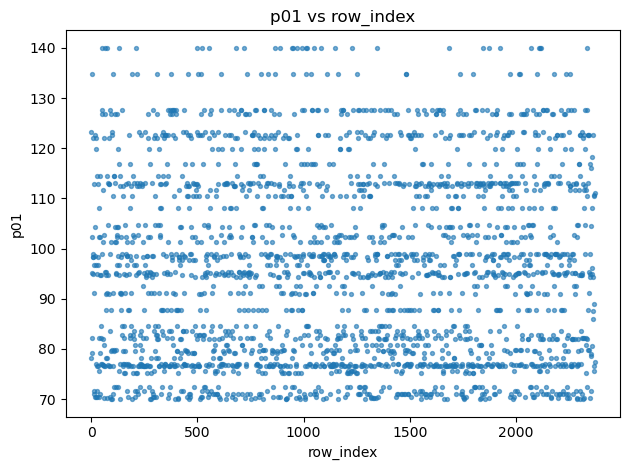

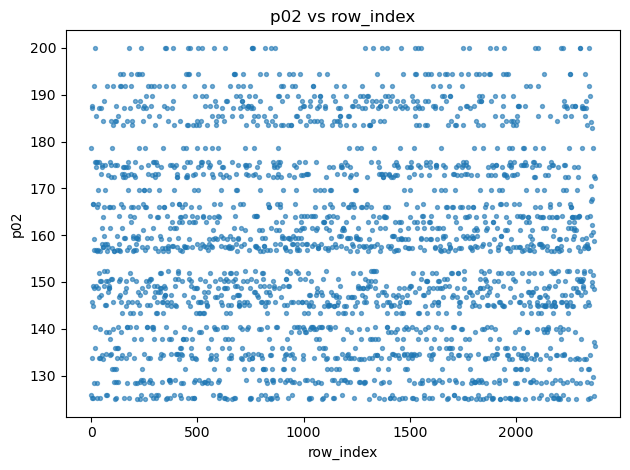

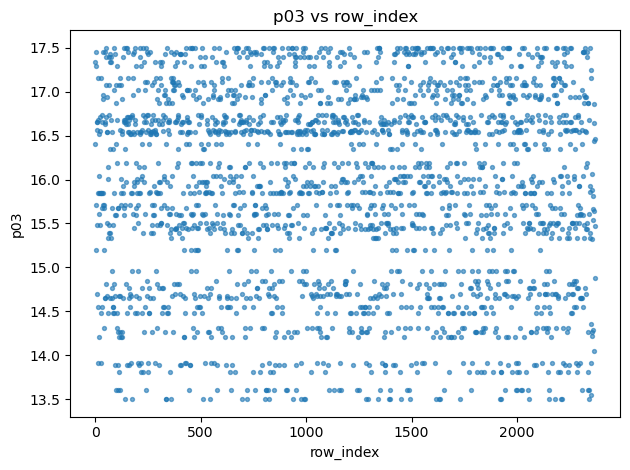

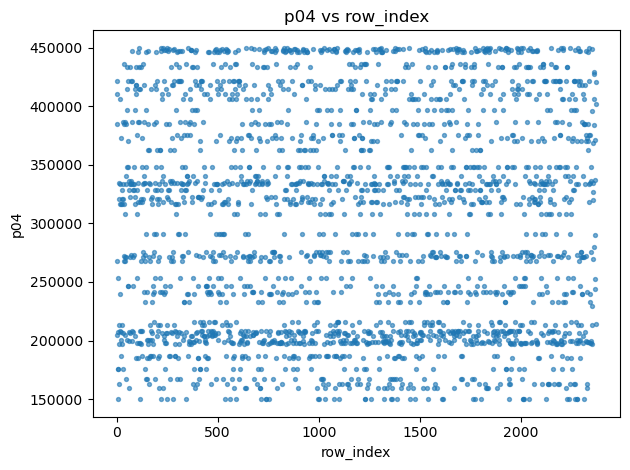

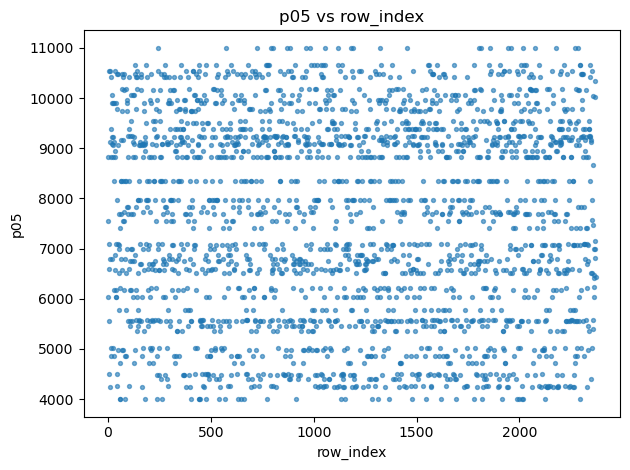

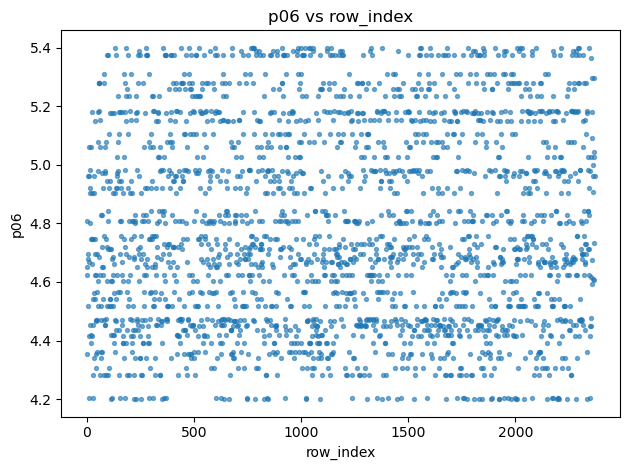

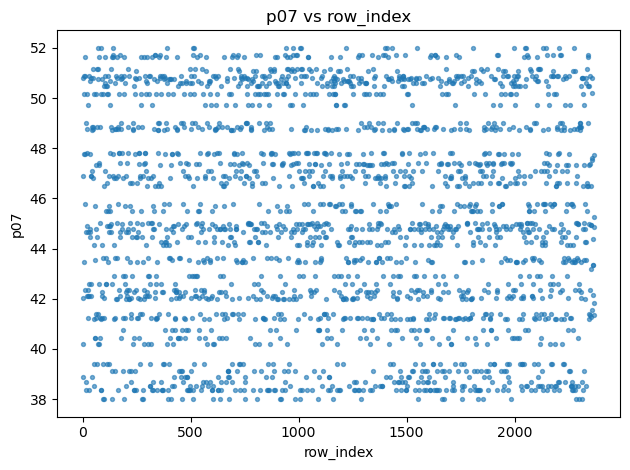

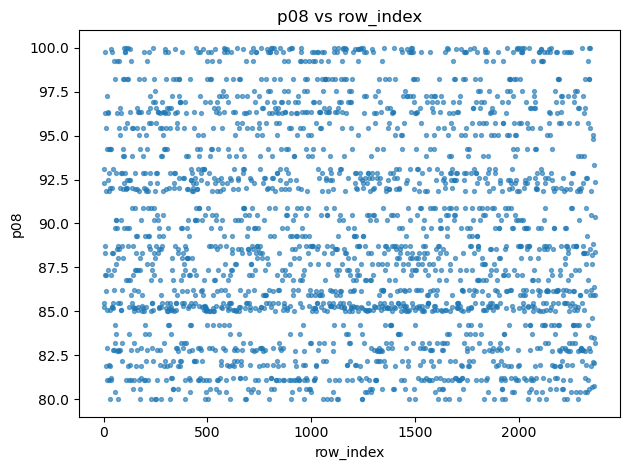

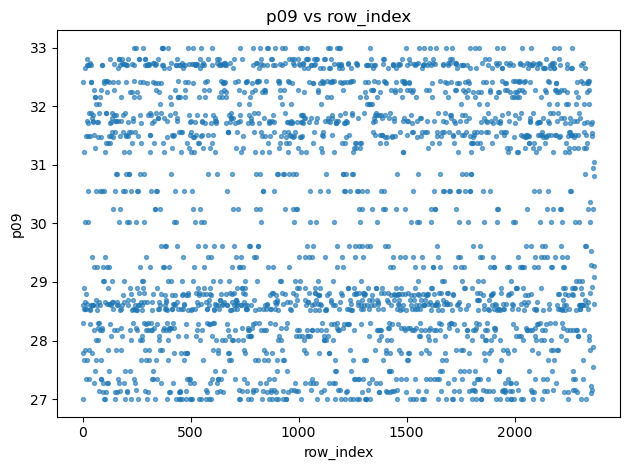

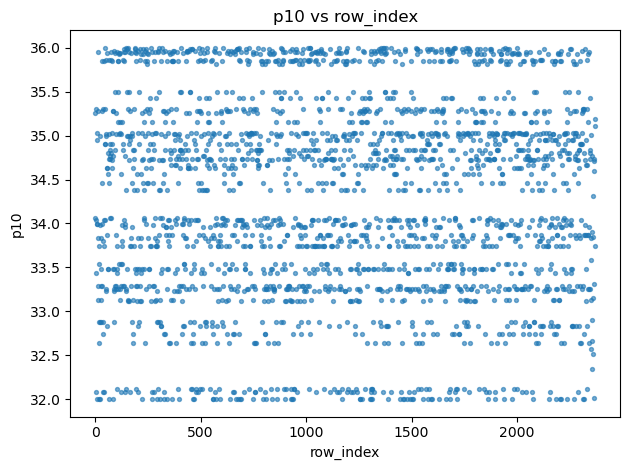

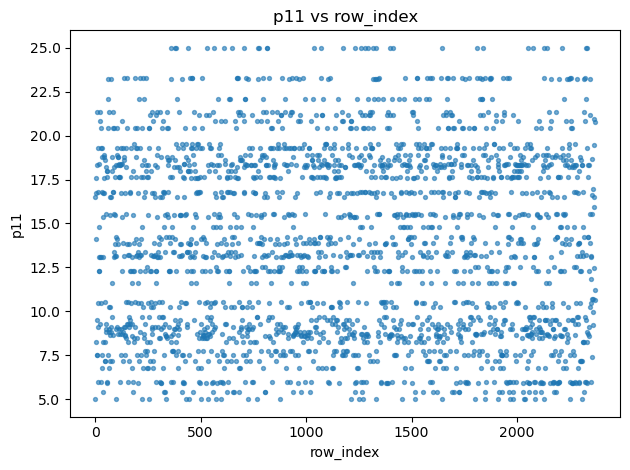

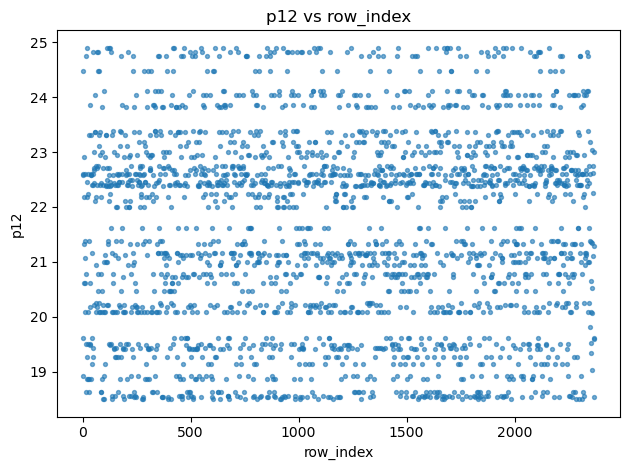

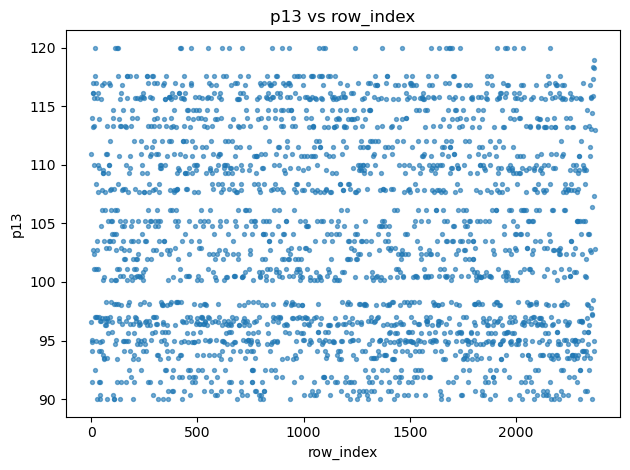

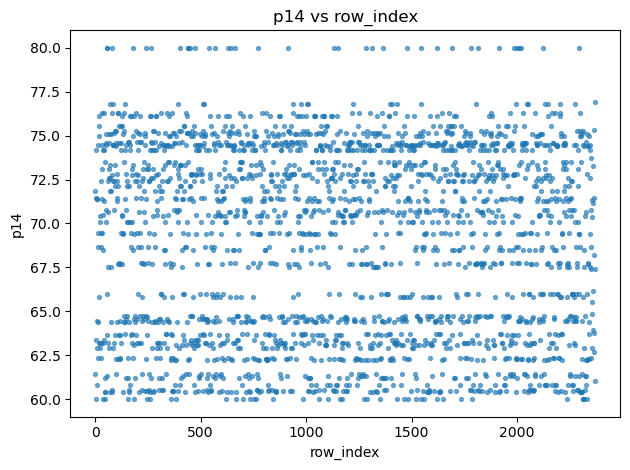

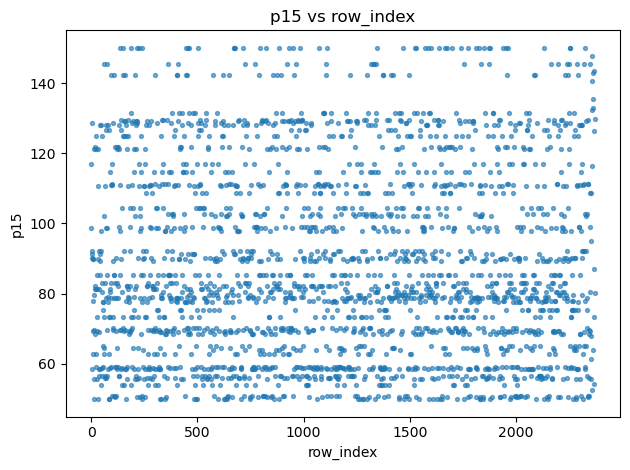

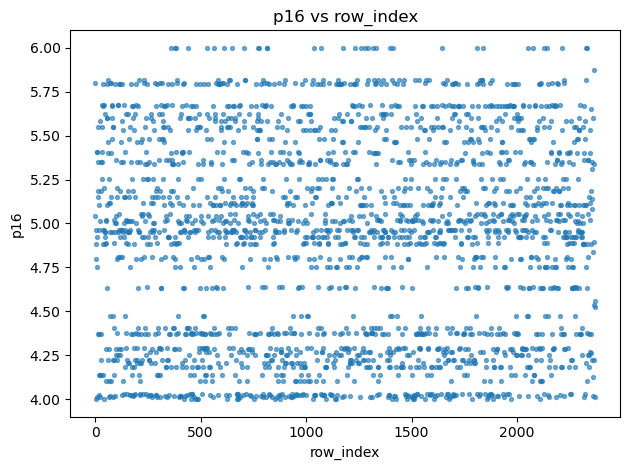

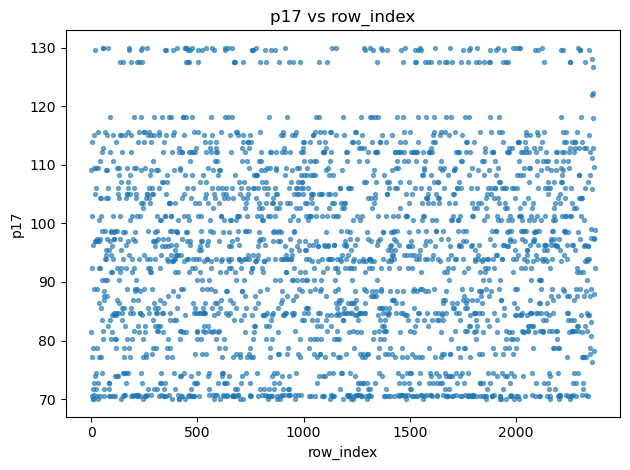

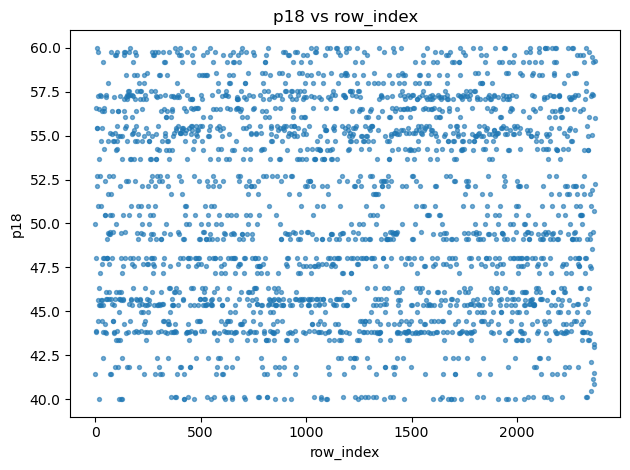

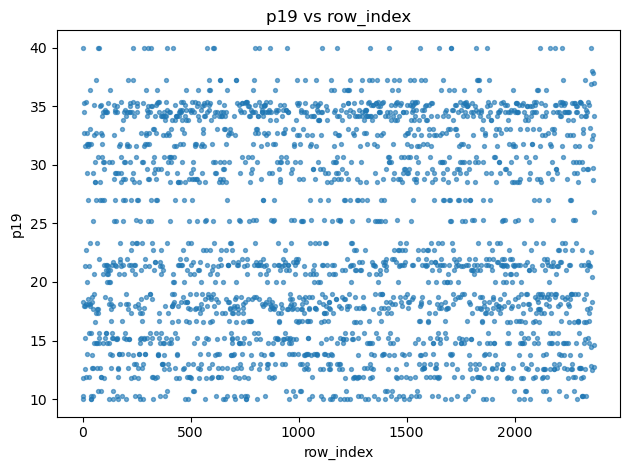

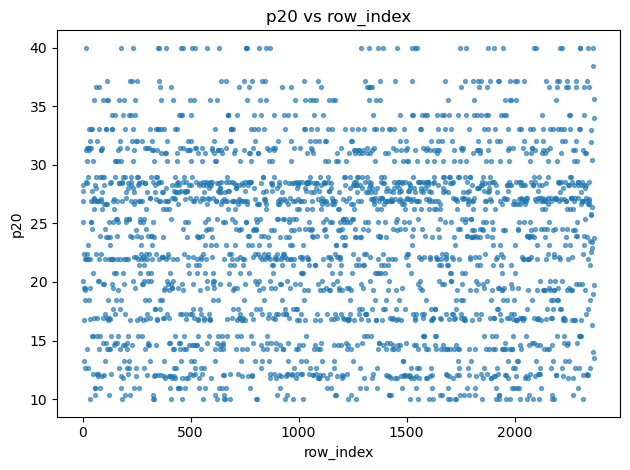

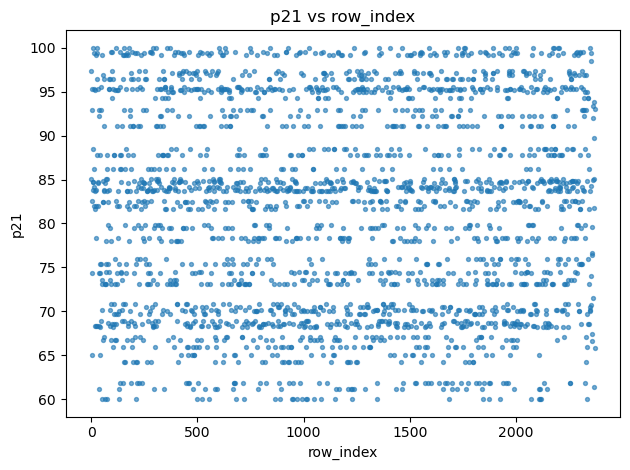

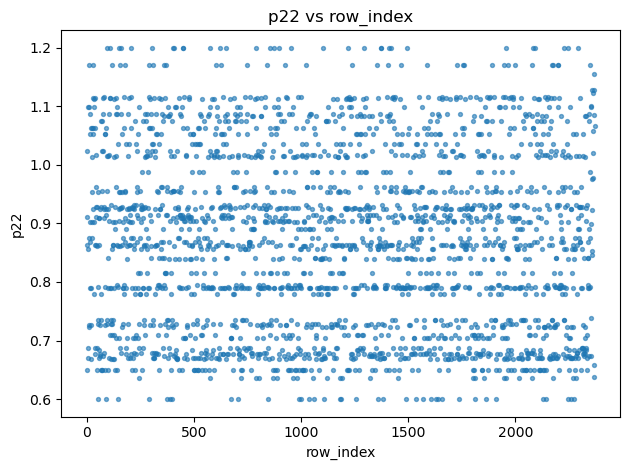

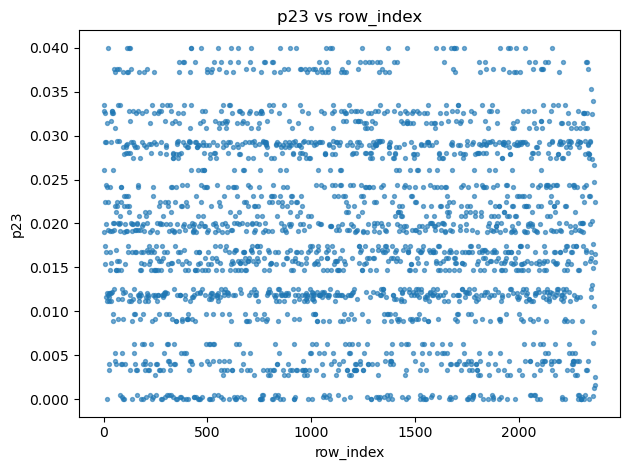

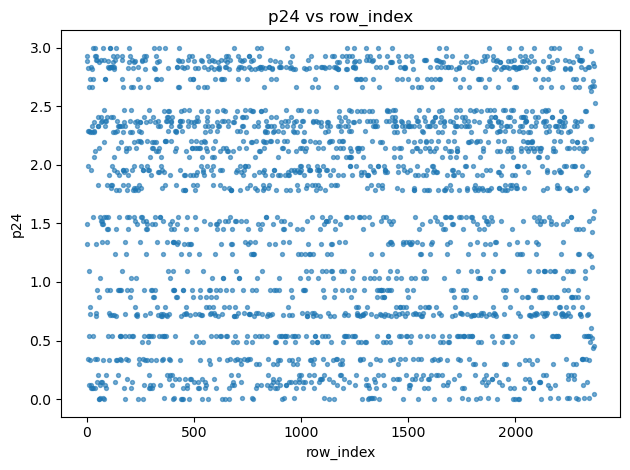

In [47]:
# Per-column scatter: value vs row index (record order)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

x = np.arange(len(df))  # record order

for col in df.columns:
    if not pd.api.types.is_numeric_dtype(df[col]):
        continue
    y = df[col]
    m = ~y.isna()
    plt.figure()
    plt.scatter(x[m], y[m], s=8, alpha=0.6)
    plt.xlabel("row_index")
    plt.ylabel(col)
    plt.title(f"{col} vs row_index")
    plt.tight_layout()
    plt.show()

# Plan for handling missing values

## What we see

* Missing values are very small in almost all columns.
* No column is mostly missing.

## Decisions for now

* We keep all columns.
* We do not drop rows just because of a few missing cells.

## How we will fill

* Numeric columns (ratio/interval): fill with the median of that column.
* Ordinal columns (if any): fill with the median to respect order.
* Nominal columns (text/category like Ailment): fill with the mode. If the mode looks misleading, we can use a separate label “Missing”.


# Analyze the "Ailment" Column

## What we see from the plot

* The bar chart shows how the classes are distributed. The first one or two classes have the largest counts, while at least one class is much smaller.
* This is a moderate class imbalance. 

## Missing values

* We printed the exact missing count and percentage above.
* If no missing values: we do nothing.
* If there are missing values:

  * If “Ailment” is the target/label: we drop those rows (they cannot be used for supervised training because the label is unknown).
  * If “Ailment” is a feature: we keep the rows and add a category “Missing” (or impute with the mode if a new category is not allowed). Using a separate “Missing” label is safer because it does not force an incorrect class.

* For a label, guessing is risky and introduces noise; dropping the few unlabeled rows is cleaner.
* For a feature, a distinct “Missing” category keeps the information that the value was absent and avoids bias from mode imputation.


Counts (including NaN):
Ailment
Anemia           623
Healthy          556
Diabetes         539
Thalasse         508
Thromboc         123
Heart Disease     20
NaN                2
Name: count, dtype: int64

Percentages (including NaN):
Ailment
Anemia          26.280
Healthy         23.450
Diabetes        22.730
Thalasse        21.430
Thromboc         5.190
Heart Disease    0.840
NaN              0.080
Name: count, dtype: float64


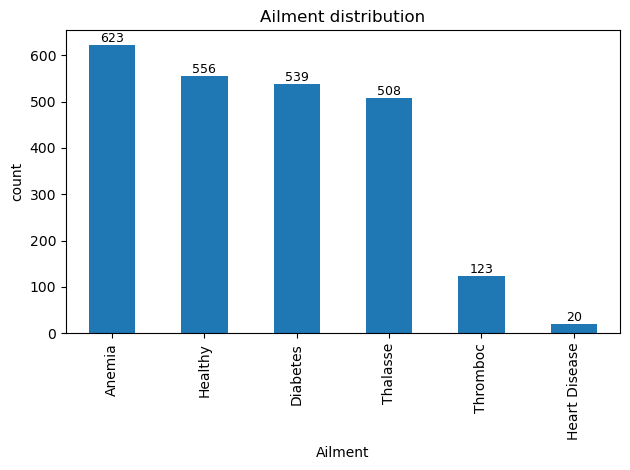

Missing in Ailment: 2 rows (0.08%) out of 2371


In [48]:
# Ailment: distribution + simple plot
import pandas as pd
import matplotlib.pyplot as plt

s = df["Ailment"]

# counts (including NaN) and percentages
vc_all = s.value_counts(dropna=False)
print("Counts (including NaN):")
print(vc_all)
print("\nPercentages (including NaN):")
print((vc_all / len(s) * 100).round(2))

# bar plot (exclude NaN for the bars)
counts = s.value_counts(dropna=True).sort_values(ascending=False)
ax = counts.plot(kind="bar")
plt.ylabel("count")
plt.title("Ailment distribution")
for i, v in enumerate(counts.values):
    plt.text(i, v, str(v), ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

# Missing check for Ailment
n = len(df)
miss_n = df["Ailment"].isna().sum()
miss_pct = (miss_n / n) * 100
print(f"Missing in Ailment: {miss_n} rows ({miss_pct:.2f}%) out of {n}")


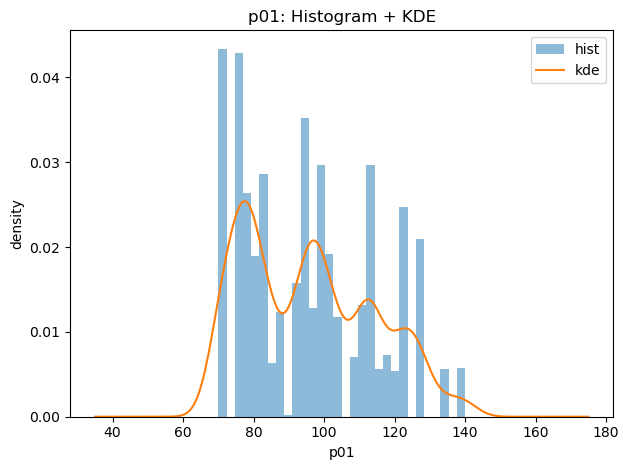

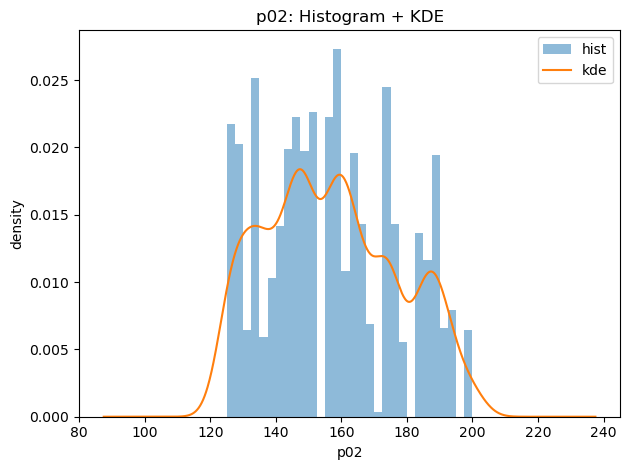

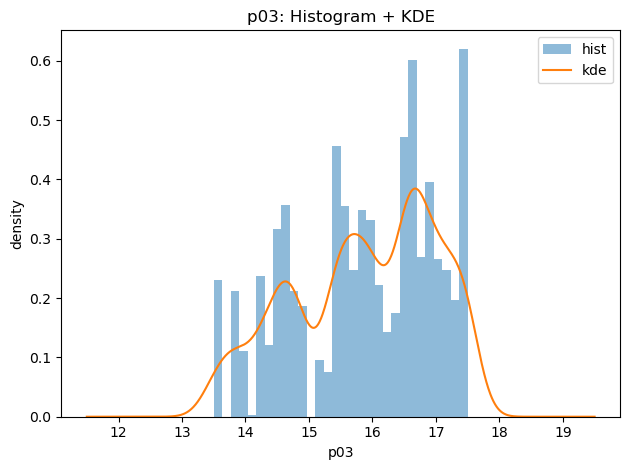

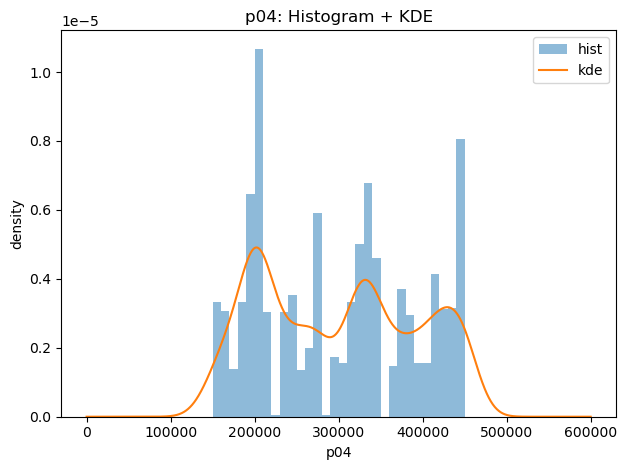

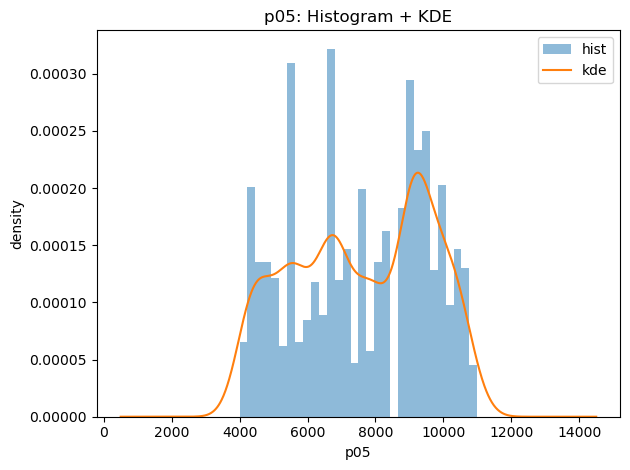

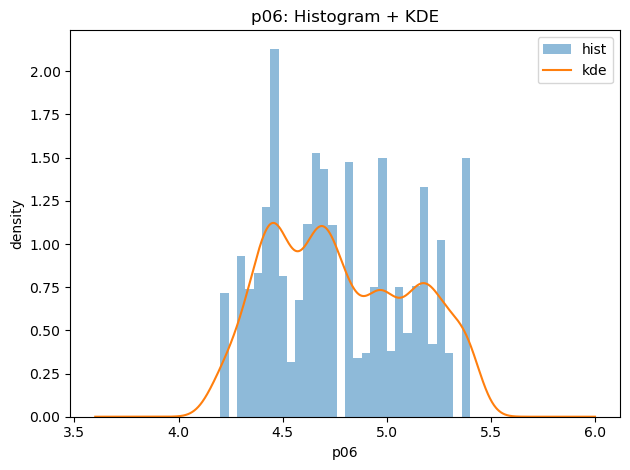

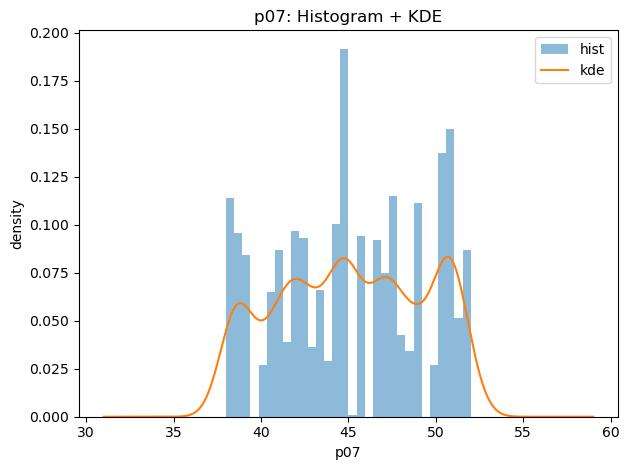

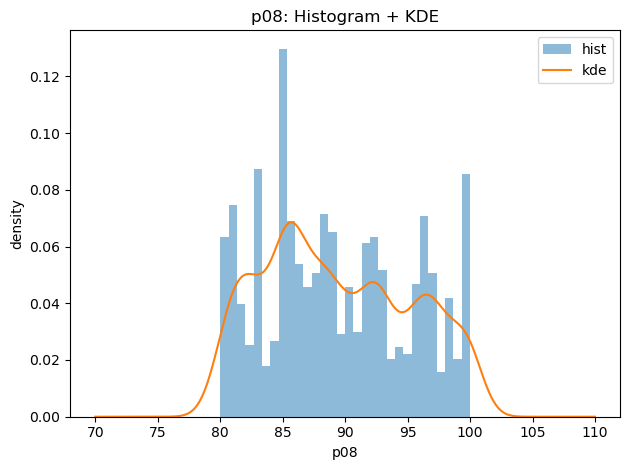

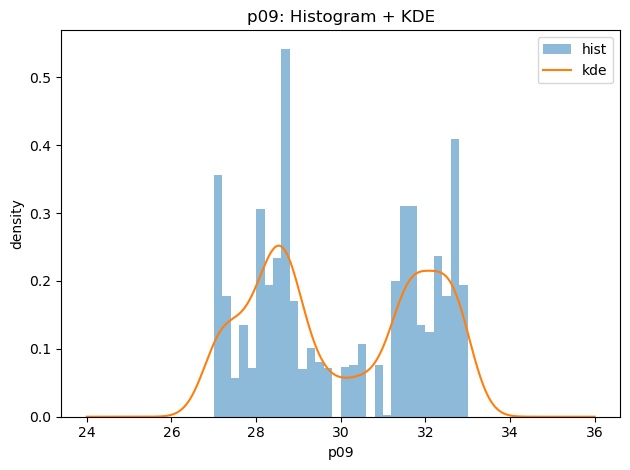

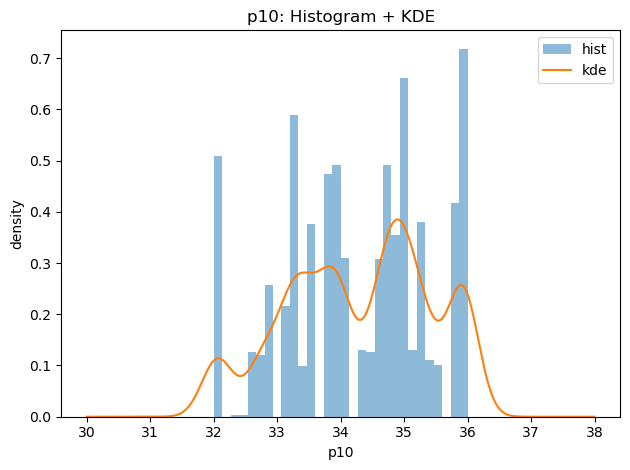

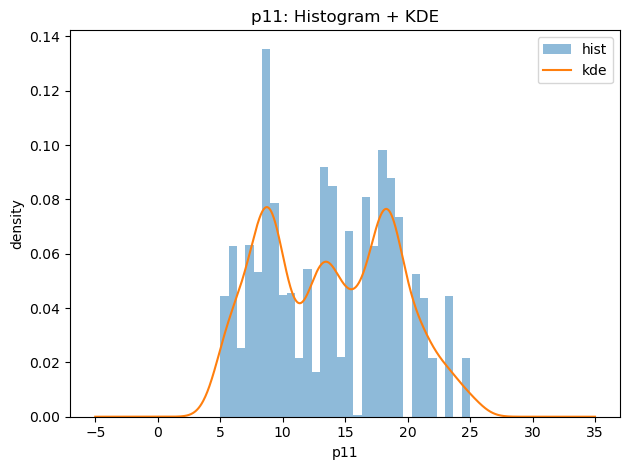

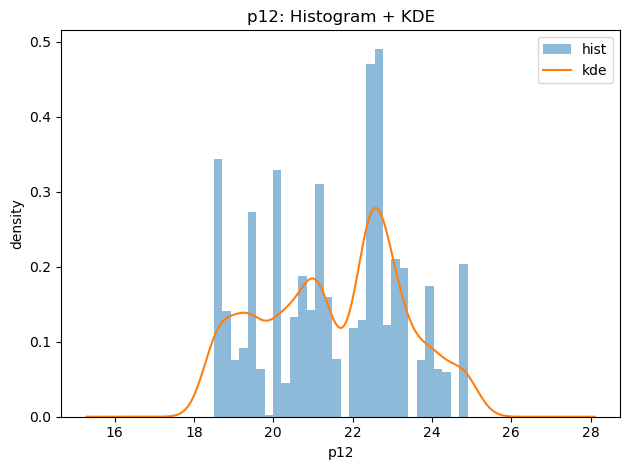

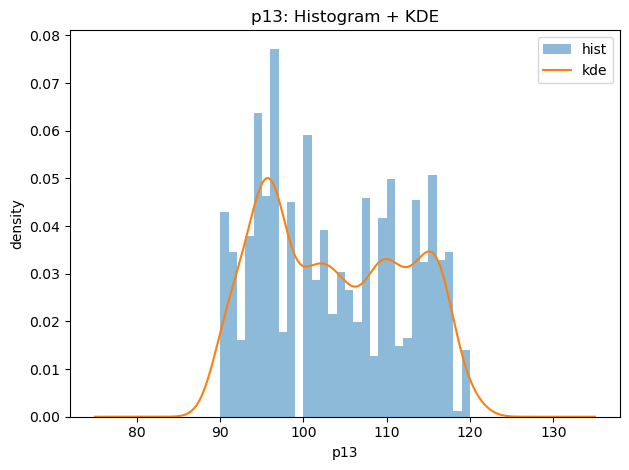

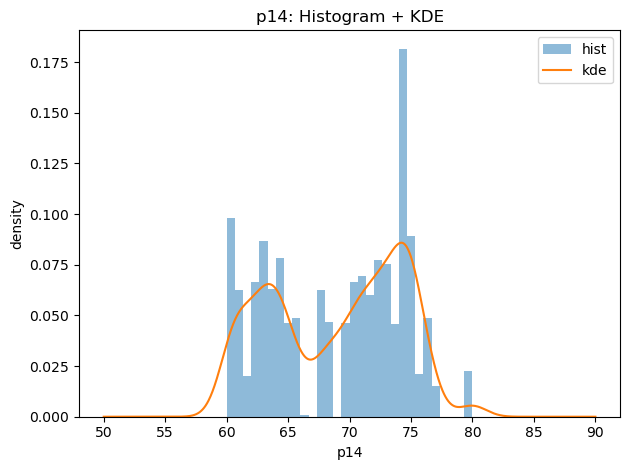

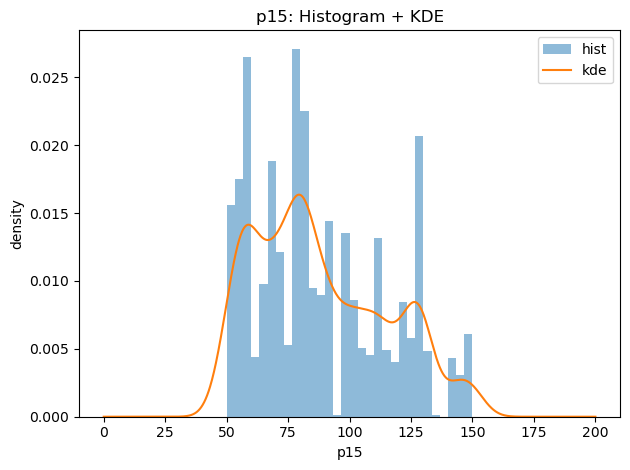

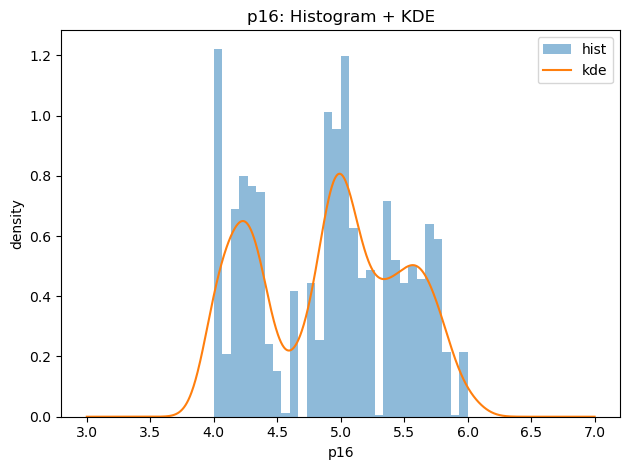

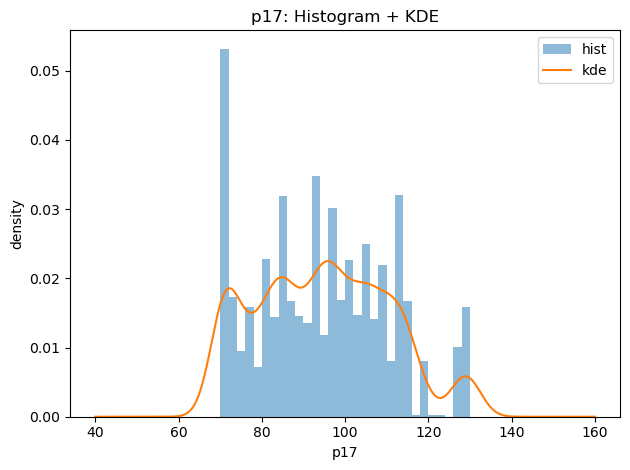

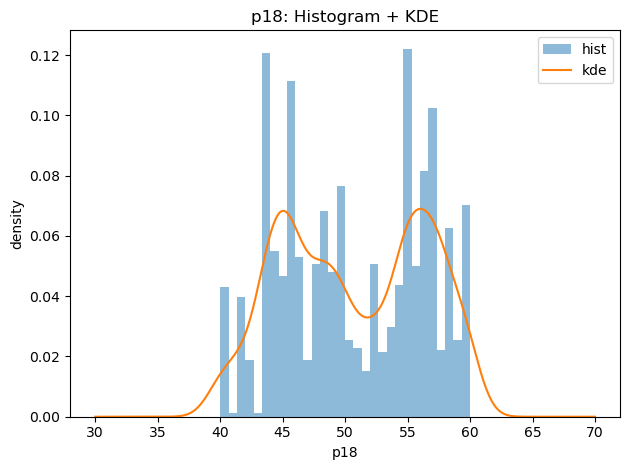

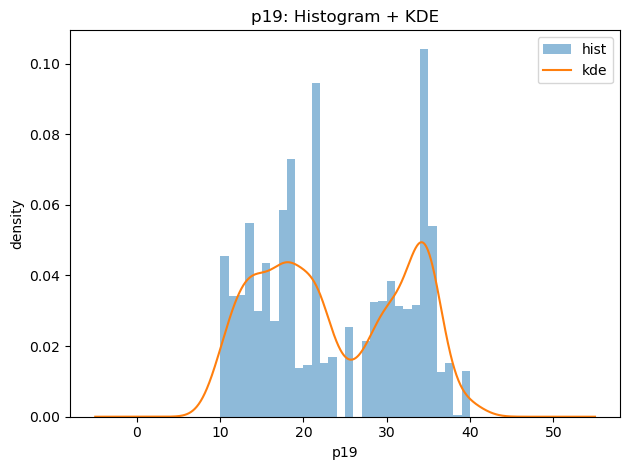

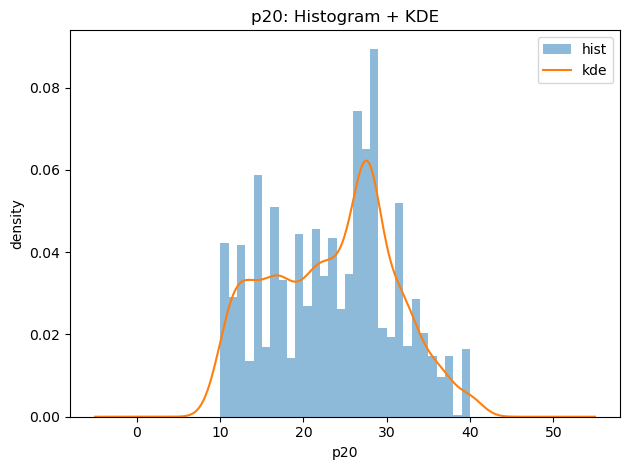

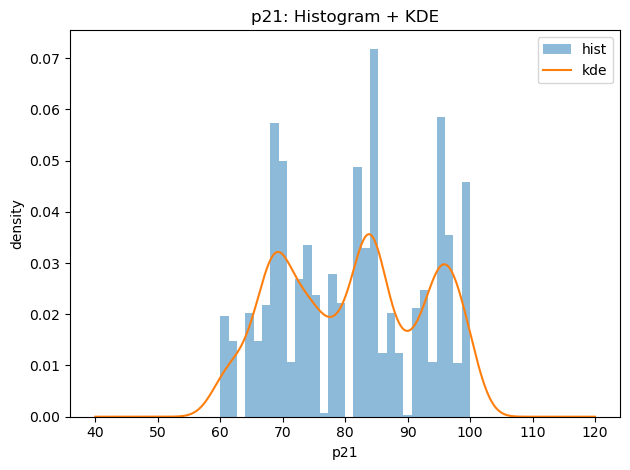

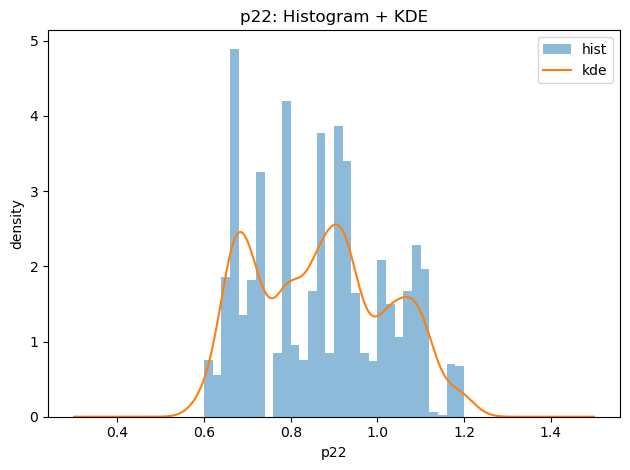

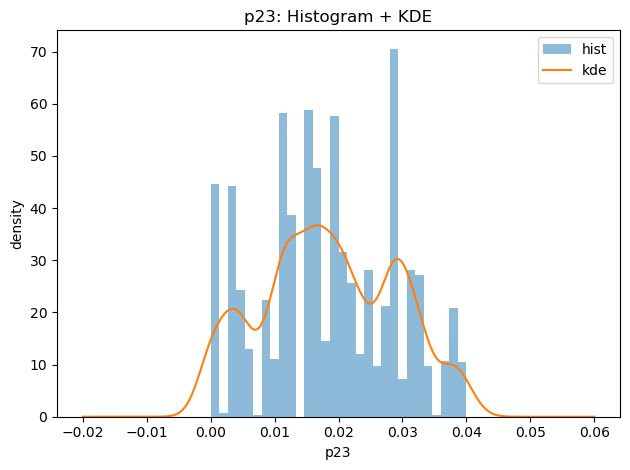

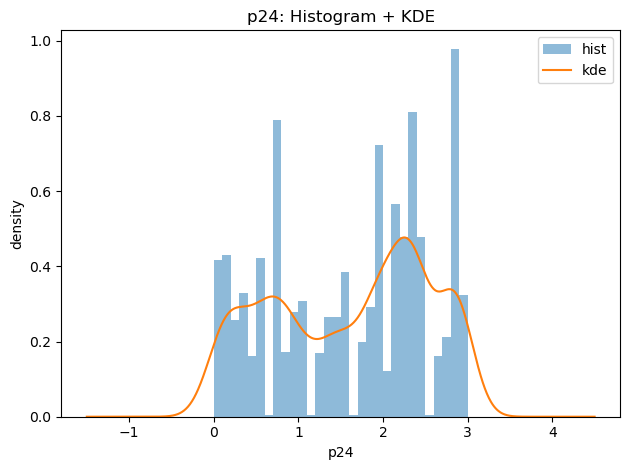

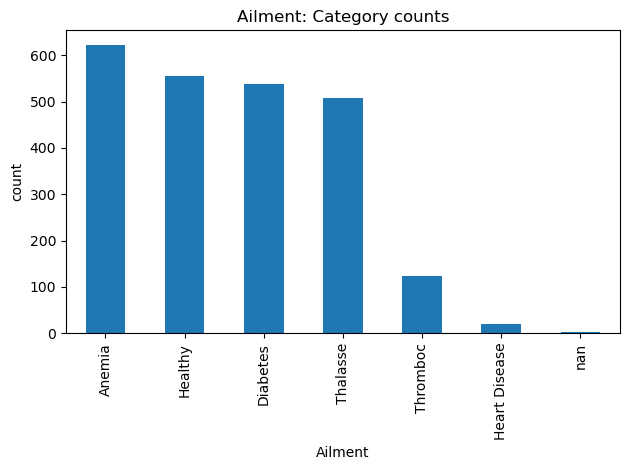

In [49]:
# Histograms and KDE (overlapped) for numeric columns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]

for col in num_cols:
    s = df[col].dropna()
    if s.empty:
        continue
    plt.figure()
    plt.hist(s, bins=30, density=True, alpha=0.5, label="hist")  # density True so scales match KDE
    s.plot(kind="kde", ax=plt.gca(), label="kde")               
    plt.xlabel(col)
    plt.ylabel("density")
    plt.title(f"{col}: Histogram + KDE")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Bar plots for non-numeric (categorical) columns (KDE is not meaningful here)
cat_cols = [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c])]

for col in cat_cols:
    s = df[col].astype("object")
    vc = s.value_counts(dropna=False)
    if vc.empty:
        continue
    plt.figure()
    vc.plot(kind="bar")
    plt.ylabel("count")
    plt.title(f"{col}: Category counts")
    plt.tight_layout()
    plt.show()



In [50]:
# summarize shapes we see 
import pandas as pd
import numpy as np

summary = []

for col in df.columns:
    s = df[col]
    if pd.api.types.is_numeric_dtype(s):
        x = s.dropna()
        if len(x) < 3:
            continue
        skew = x.skew()
        zero_rate = (x == 0).mean() if (x.dtype != "O" and len(x) > 0) else np.nan
        summary.append((col, skew, zero_rate))

shape_tbl = pd.DataFrame(summary, columns=["column","skew","zero_rate"]).sort_values("skew")
print("Skew and zero-rate (for reference):")
print(shape_tbl.to_string(index=False, float_format=lambda v: f"{v:.3f}" if isinstance(v, float) else str(v)))


Skew and zero-rate (for reference):
column   skew  zero_rate
   p03 -0.391      0.000
   p10 -0.245      0.000
   p24 -0.228      0.015
   p14 -0.149      0.000
   p05 -0.148      0.000
   p12 -0.078      0.000
   p07 -0.069      0.000
   p16 -0.041      0.000
   p18 -0.036      0.000
   p20 -0.029      0.000
   p21 -0.002      0.000
   p09  0.046      0.000
   p23  0.051      0.016
   p19  0.097      0.000
   p11  0.098      0.000
   p04  0.120      0.000
   p13  0.155      0.000
   p22  0.178      0.000
   p06  0.214      0.000
   p08  0.232      0.000
   p17  0.234      0.000
   p02  0.252      0.000
   p01  0.414      0.000
   p15  0.505      0.000


# Conclusions 

### What KDE represents

* A KDE curve is a smooth estimate of the distribution (a smoothed version of the histogram).
* Peaks show where values are dense; long tails show skew; multiple bumps suggest multi-modal behavior.

### How to read the plots here

* Histogram + KDE (numeric):

  * If the KDE is roughly bell-shaped and centered, the variable is close to symmetric.
  * A right tail (long tail to the right) means right-skew; a left tail means left-skew.
  * Multiple bumps can mean subgroups or mixed processes.
  * Very narrow, tall peaks may indicate near-constant values or heavy rounding.
* Bar plots (categorical): show how the categories are distributed; tall bars tell you the dominant classes.

### Significant conclusions

* Skewed variables: Check the printed `summary` table. Columns with `|skew| >= 1` are strongly skewed.

  * For those, consider log / square-root transforms (if values are non-negative) or use robust statistics (median/IQR).
* Zero-inflated variables: If `zero_%` is high (e.g., >=50%), the histogram will show a spike at 0.

  * Treat them carefully: sometimes a two-part modeling strategy (is zero vs nonzero, then model positive values) works better.


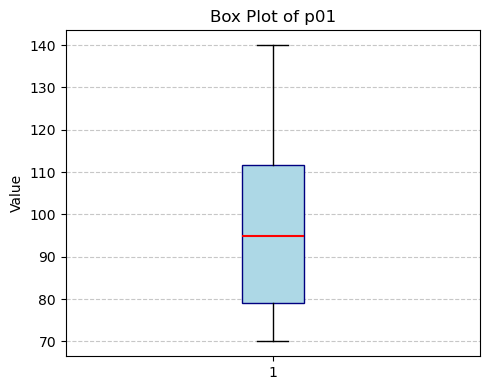

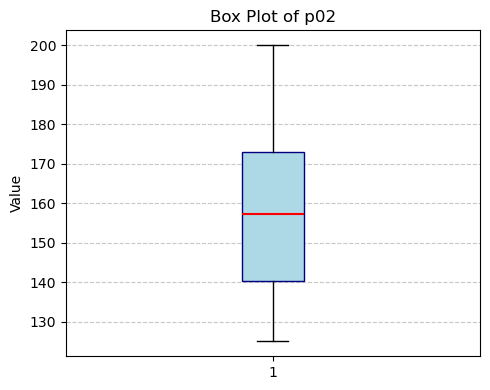

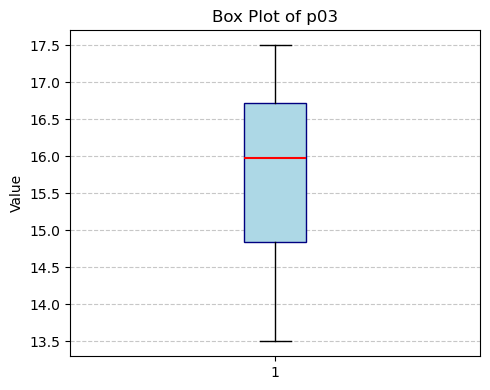

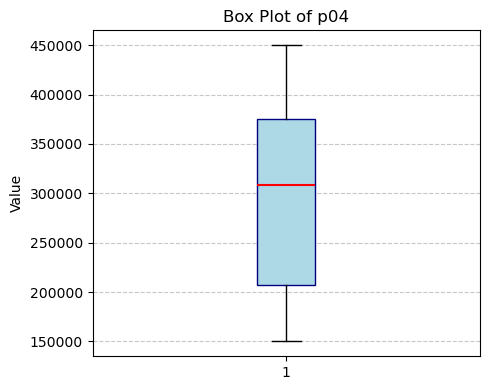

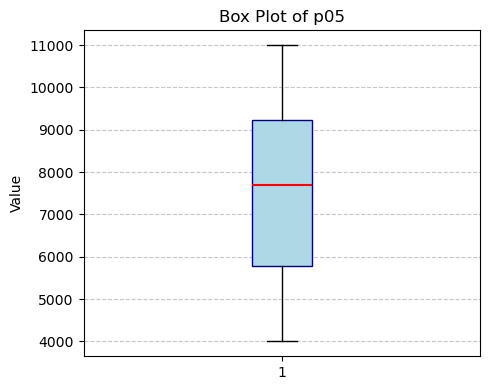

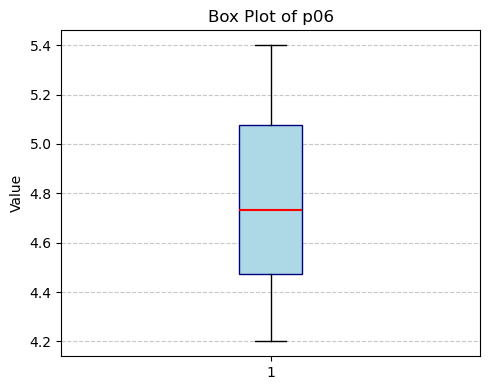

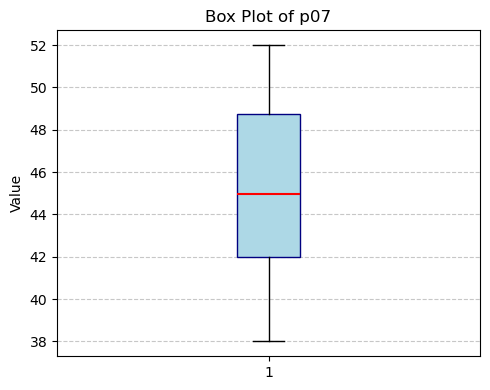

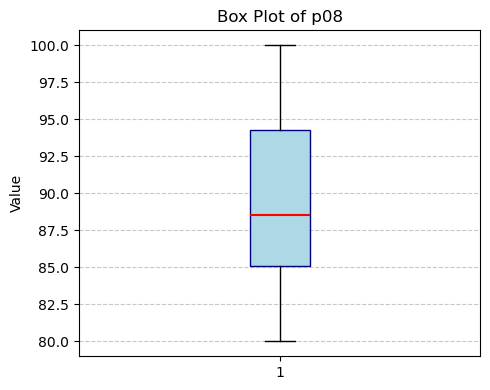

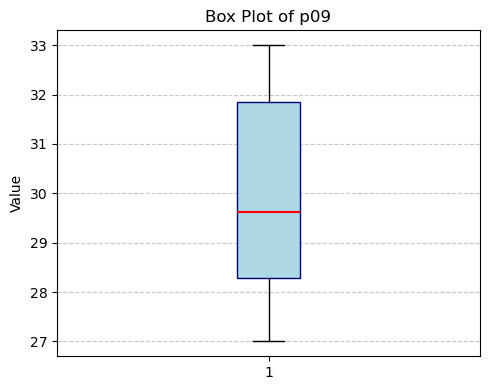

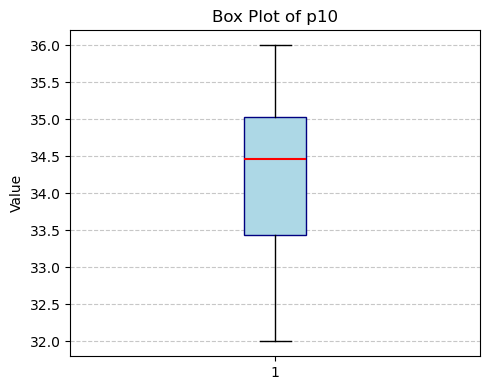

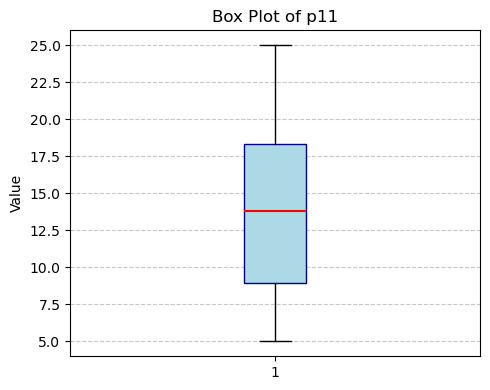

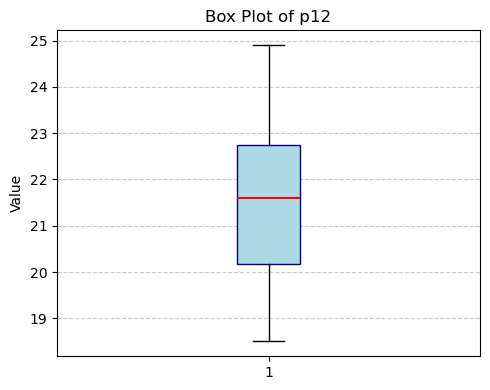

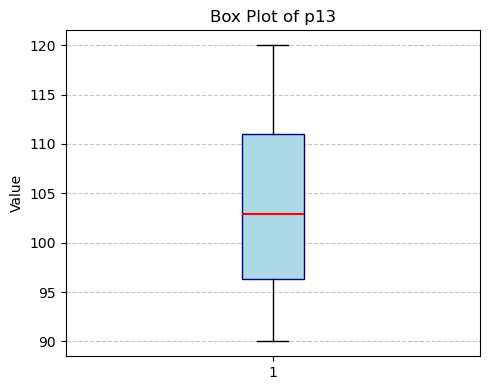

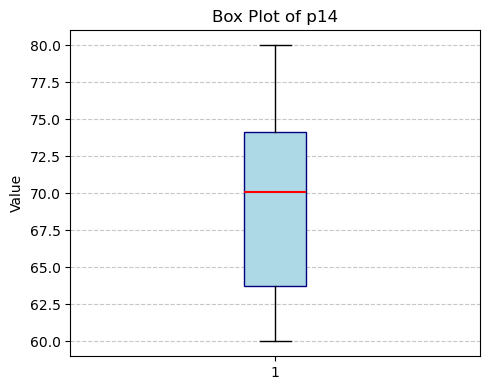

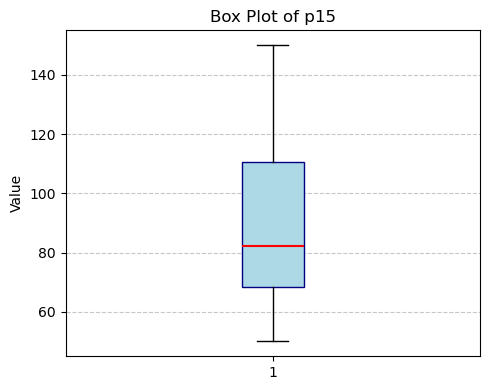

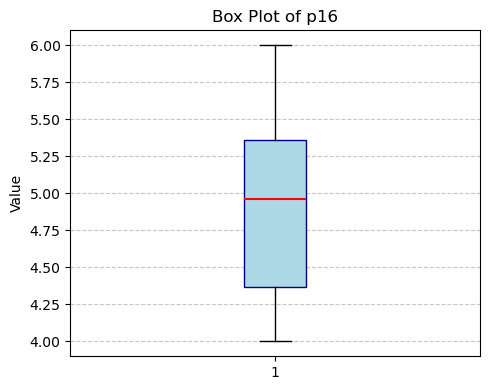

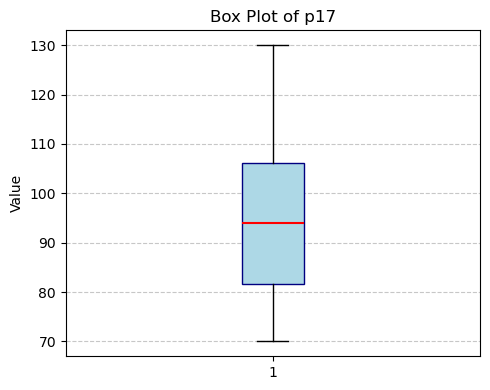

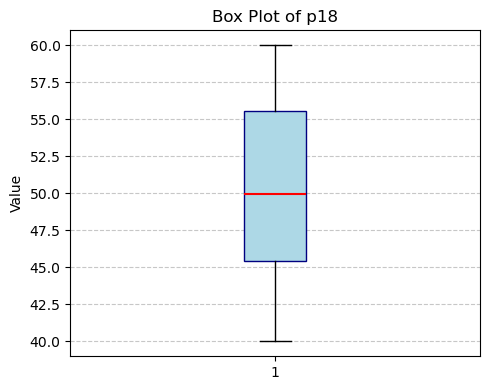

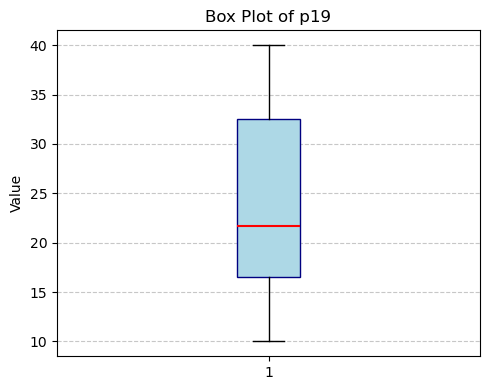

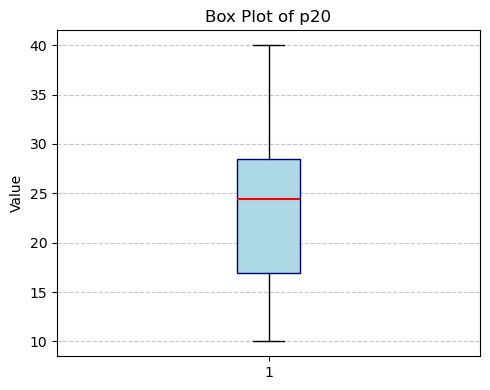

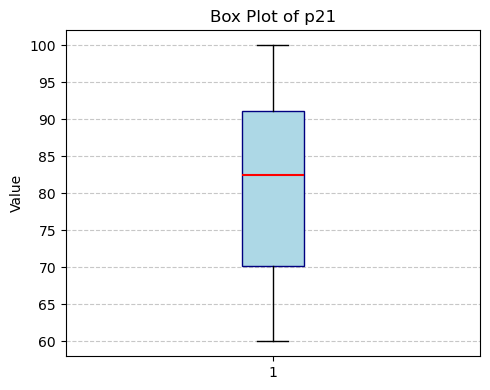

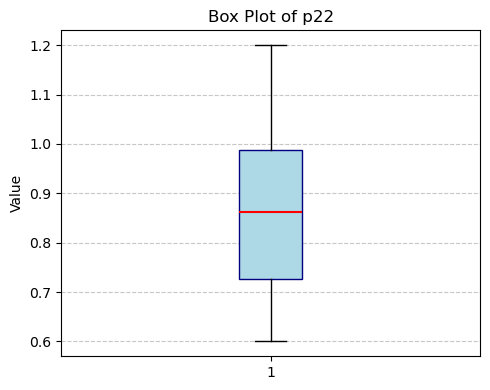

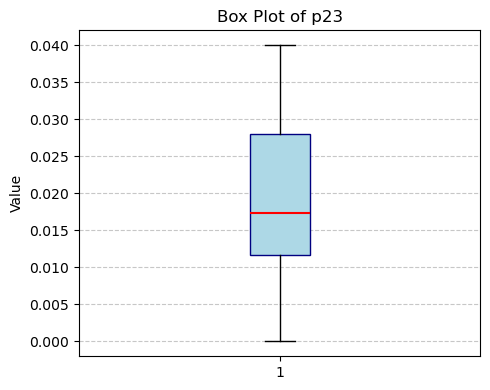

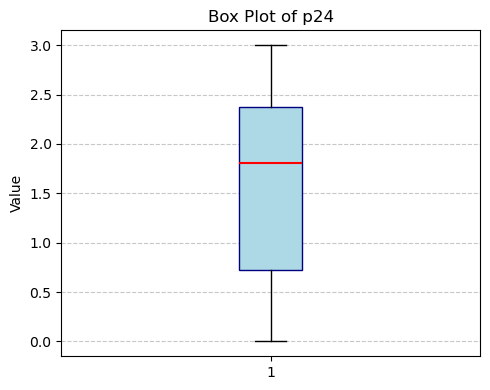

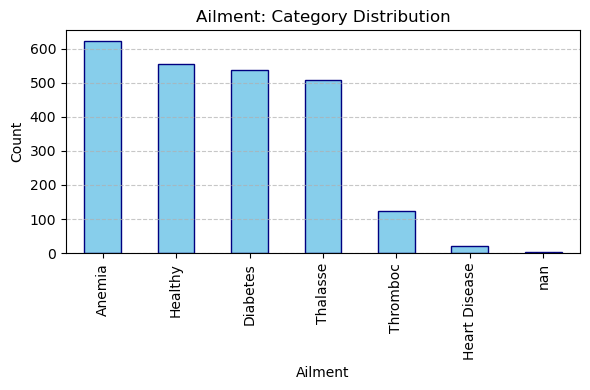

In [51]:
# Q8: Box plots for all columns (numeric and categorical separately)

import pandas as pd
import matplotlib.pyplot as plt

# Identify numeric and categorical columns
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c])]

# --- Numeric Columns: Boxplots ---
for col in num_cols:
    s = df[col].dropna()
    if s.empty:
        continue
    plt.figure(figsize=(5, 4))
    plt.boxplot(s, vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='navy'),
                medianprops=dict(color='red', linewidth=1.5))
    plt.title(f"Box Plot of {col}")
    plt.ylabel("Value")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# --- Categorical Columns: Category Count Boxplots (if numeric relation exists) ---
# For purely categorical data, boxplots are not meaningful, so show counts
for col in cat_cols:
    vc = df[col].value_counts(dropna=False)
    if vc.empty:
        continue
    plt.figure(figsize=(6, 4))
    vc.plot(kind="bar", color='skyblue', edgecolor='navy')
    plt.title(f"{col}: Category Distribution")
    plt.ylabel("Count")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# How Box Plots Help?

A box plot visually summarizes the spread and symmetry of a variable:

The box shows the interquartile range (IQR = Q3 - Q1) → the middle 50% of data.

The line inside the box is the median → central tendency.

Whiskers extend up to 1.5 × IQR from Q1 and Q3.

Points outside whiskers → potential outliers.

The height of the box → how spread the data is.

The position of the median line → whether the data is skewed.

# Conclusions (from analysis of box plots)
### 1. Spread and Central Tendency

Most numeric variables show moderate spread (boxes not too tall or compressed).

The median is roughly central in many variables → indicates near-symmetric distributions.

For variables like p04 and p05, the boxes are tall with large whiskers, confirming high variance or wide data range.

### 2.No Outliers

### 3.Symmetry and Skewness

If the median line is not centered (closer to top or bottom of the box), the data is skewed:

Median near bottom → right-skewed.

Median near top → left-skewed.

This observation matches the KDE/histogram findings:
A few variables are slightly right-skewed.

# Categorical Columns

For “Ailment,” the bar plot again confirms class imbalance — “Anemia” being the dominant category (~26%).

No extreme rarity or missing categories, so the class distribution is usable.

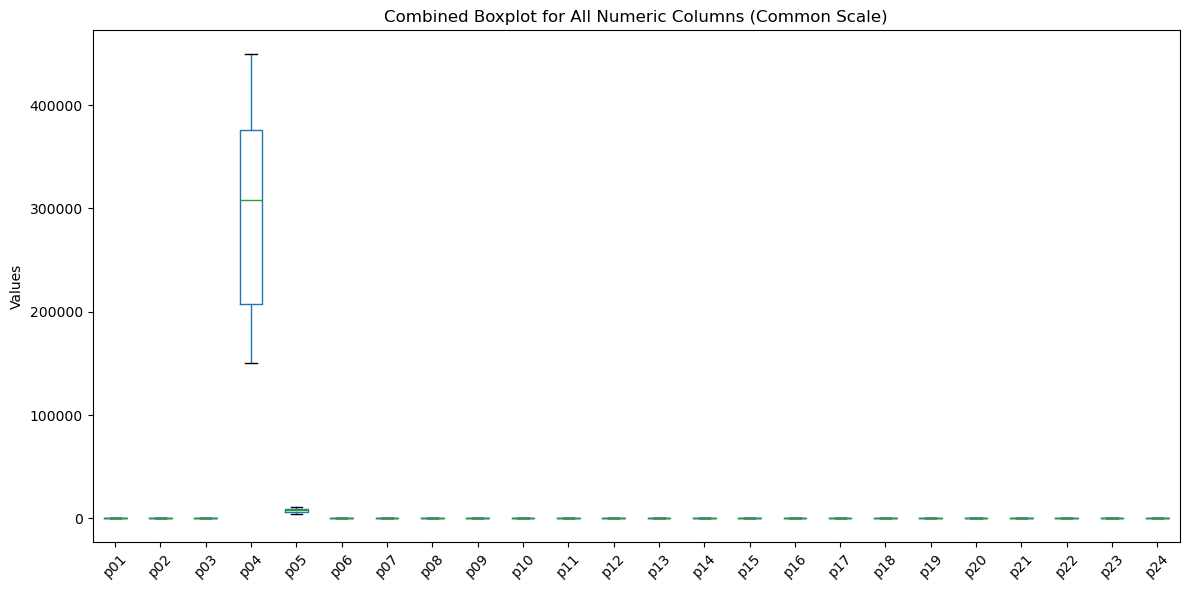

           mean        std         min         25%         50%         75%  \
p01      95.724     18.391      70.000      79.045      94.911     111.766   
p02     157.056     20.087     125.000     140.428     157.334     172.882   
p03      15.876      1.108      13.500      14.841      15.976      16.716   
p04 299,642.033 92,072.554 150,000.000 207,236.904 308,502.922 375,652.950   
p05   7,576.393  1,975.407   4,000.000   5,779.743   7,692.153   9,232.442   
p06       4.781      0.335       4.200       4.475       4.731       5.078   
p07      45.176      4.131      38.000      42.006      44.982      48.755   
p08      89.369      5.810      80.000      85.074      88.565      94.243   
p09      30.013      1.965      27.000      28.293      29.619      31.847   
p10      34.288      1.129      32.000      33.440      34.464      35.033   
p11      13.854      5.197       5.000       8.967      13.807      18.302   
p12      21.550      1.758      18.500      20.182      21.608  

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Select numeric columns
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]

# Combine all boxplots on the same scale
plt.figure(figsize=(12, 6))
df.boxplot(column=num_cols, grid=False)
plt.title("Combined Boxplot for All Numeric Columns (Common Scale)")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Also check summary statistics to support conclusions
print(df[num_cols].describe().T[["mean", "std", "min", "25%", "50%", "75%", "max"]])


### Conclusion and Implication 
The combined boxplot shows that p04 and p05 dominate the numeric range, while all other variables operate on much smaller scales.
This confirms the dataset needs scaling for fair comparison and effective downstream analysis.

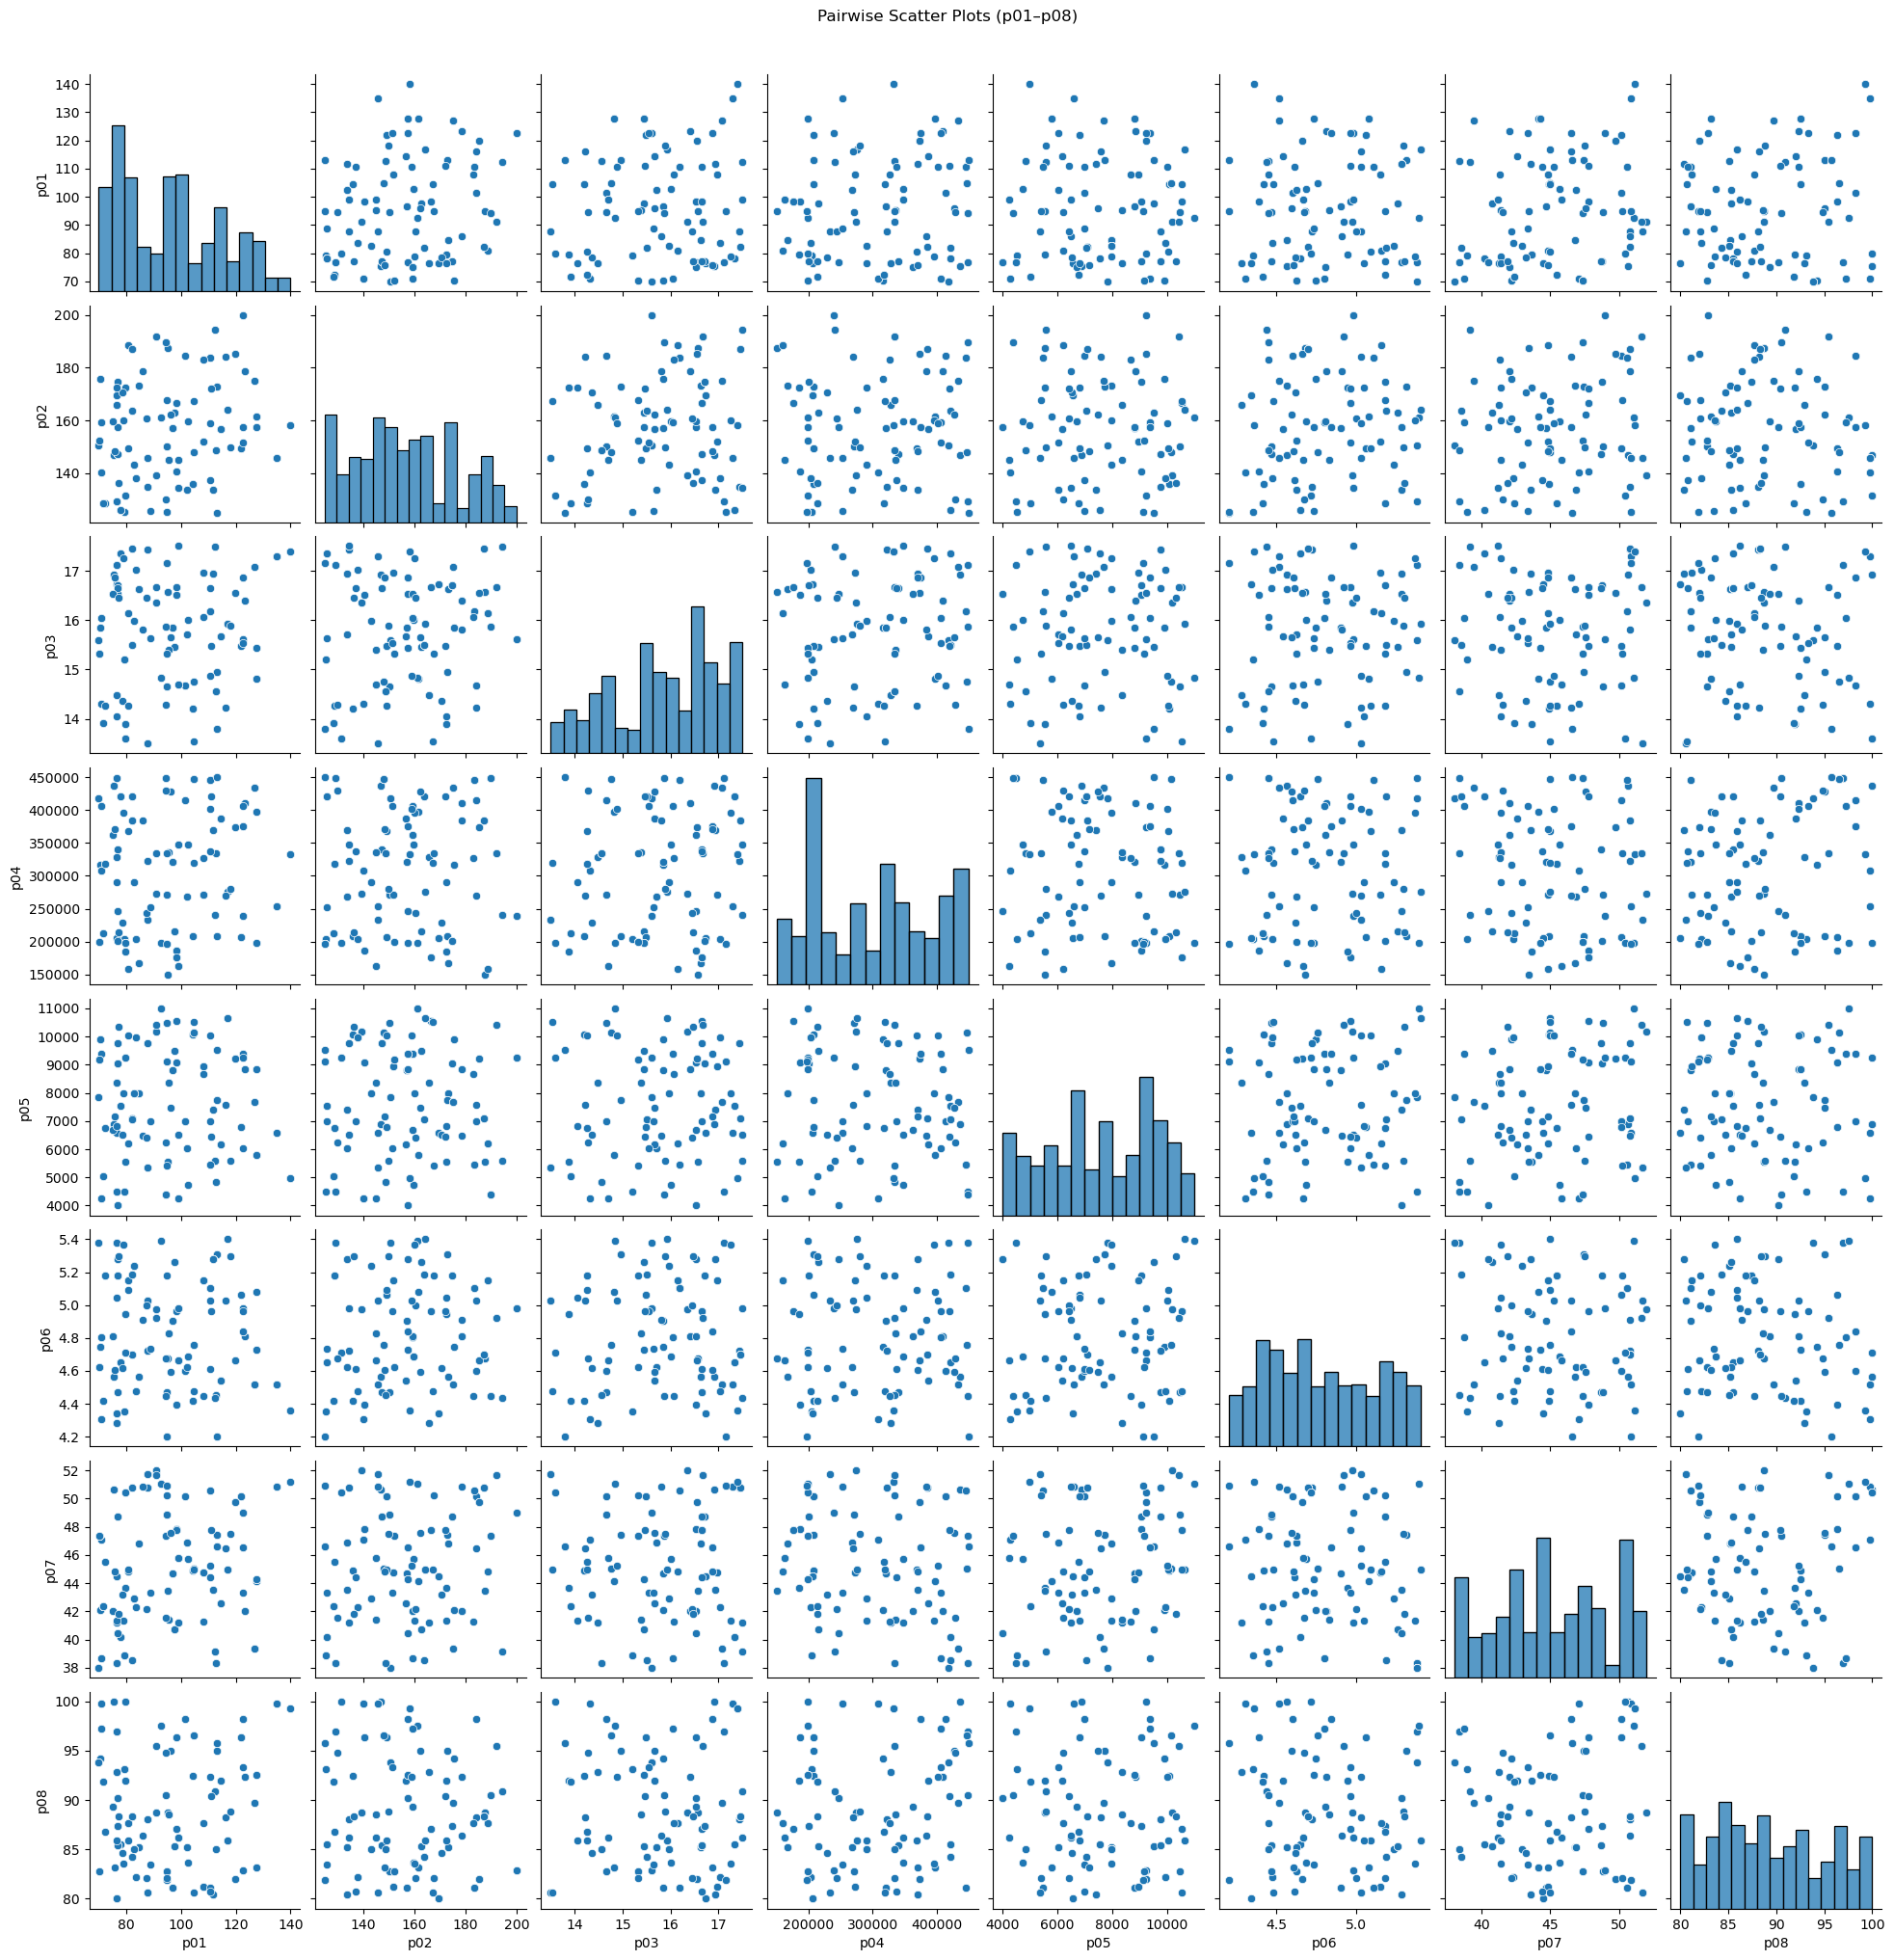

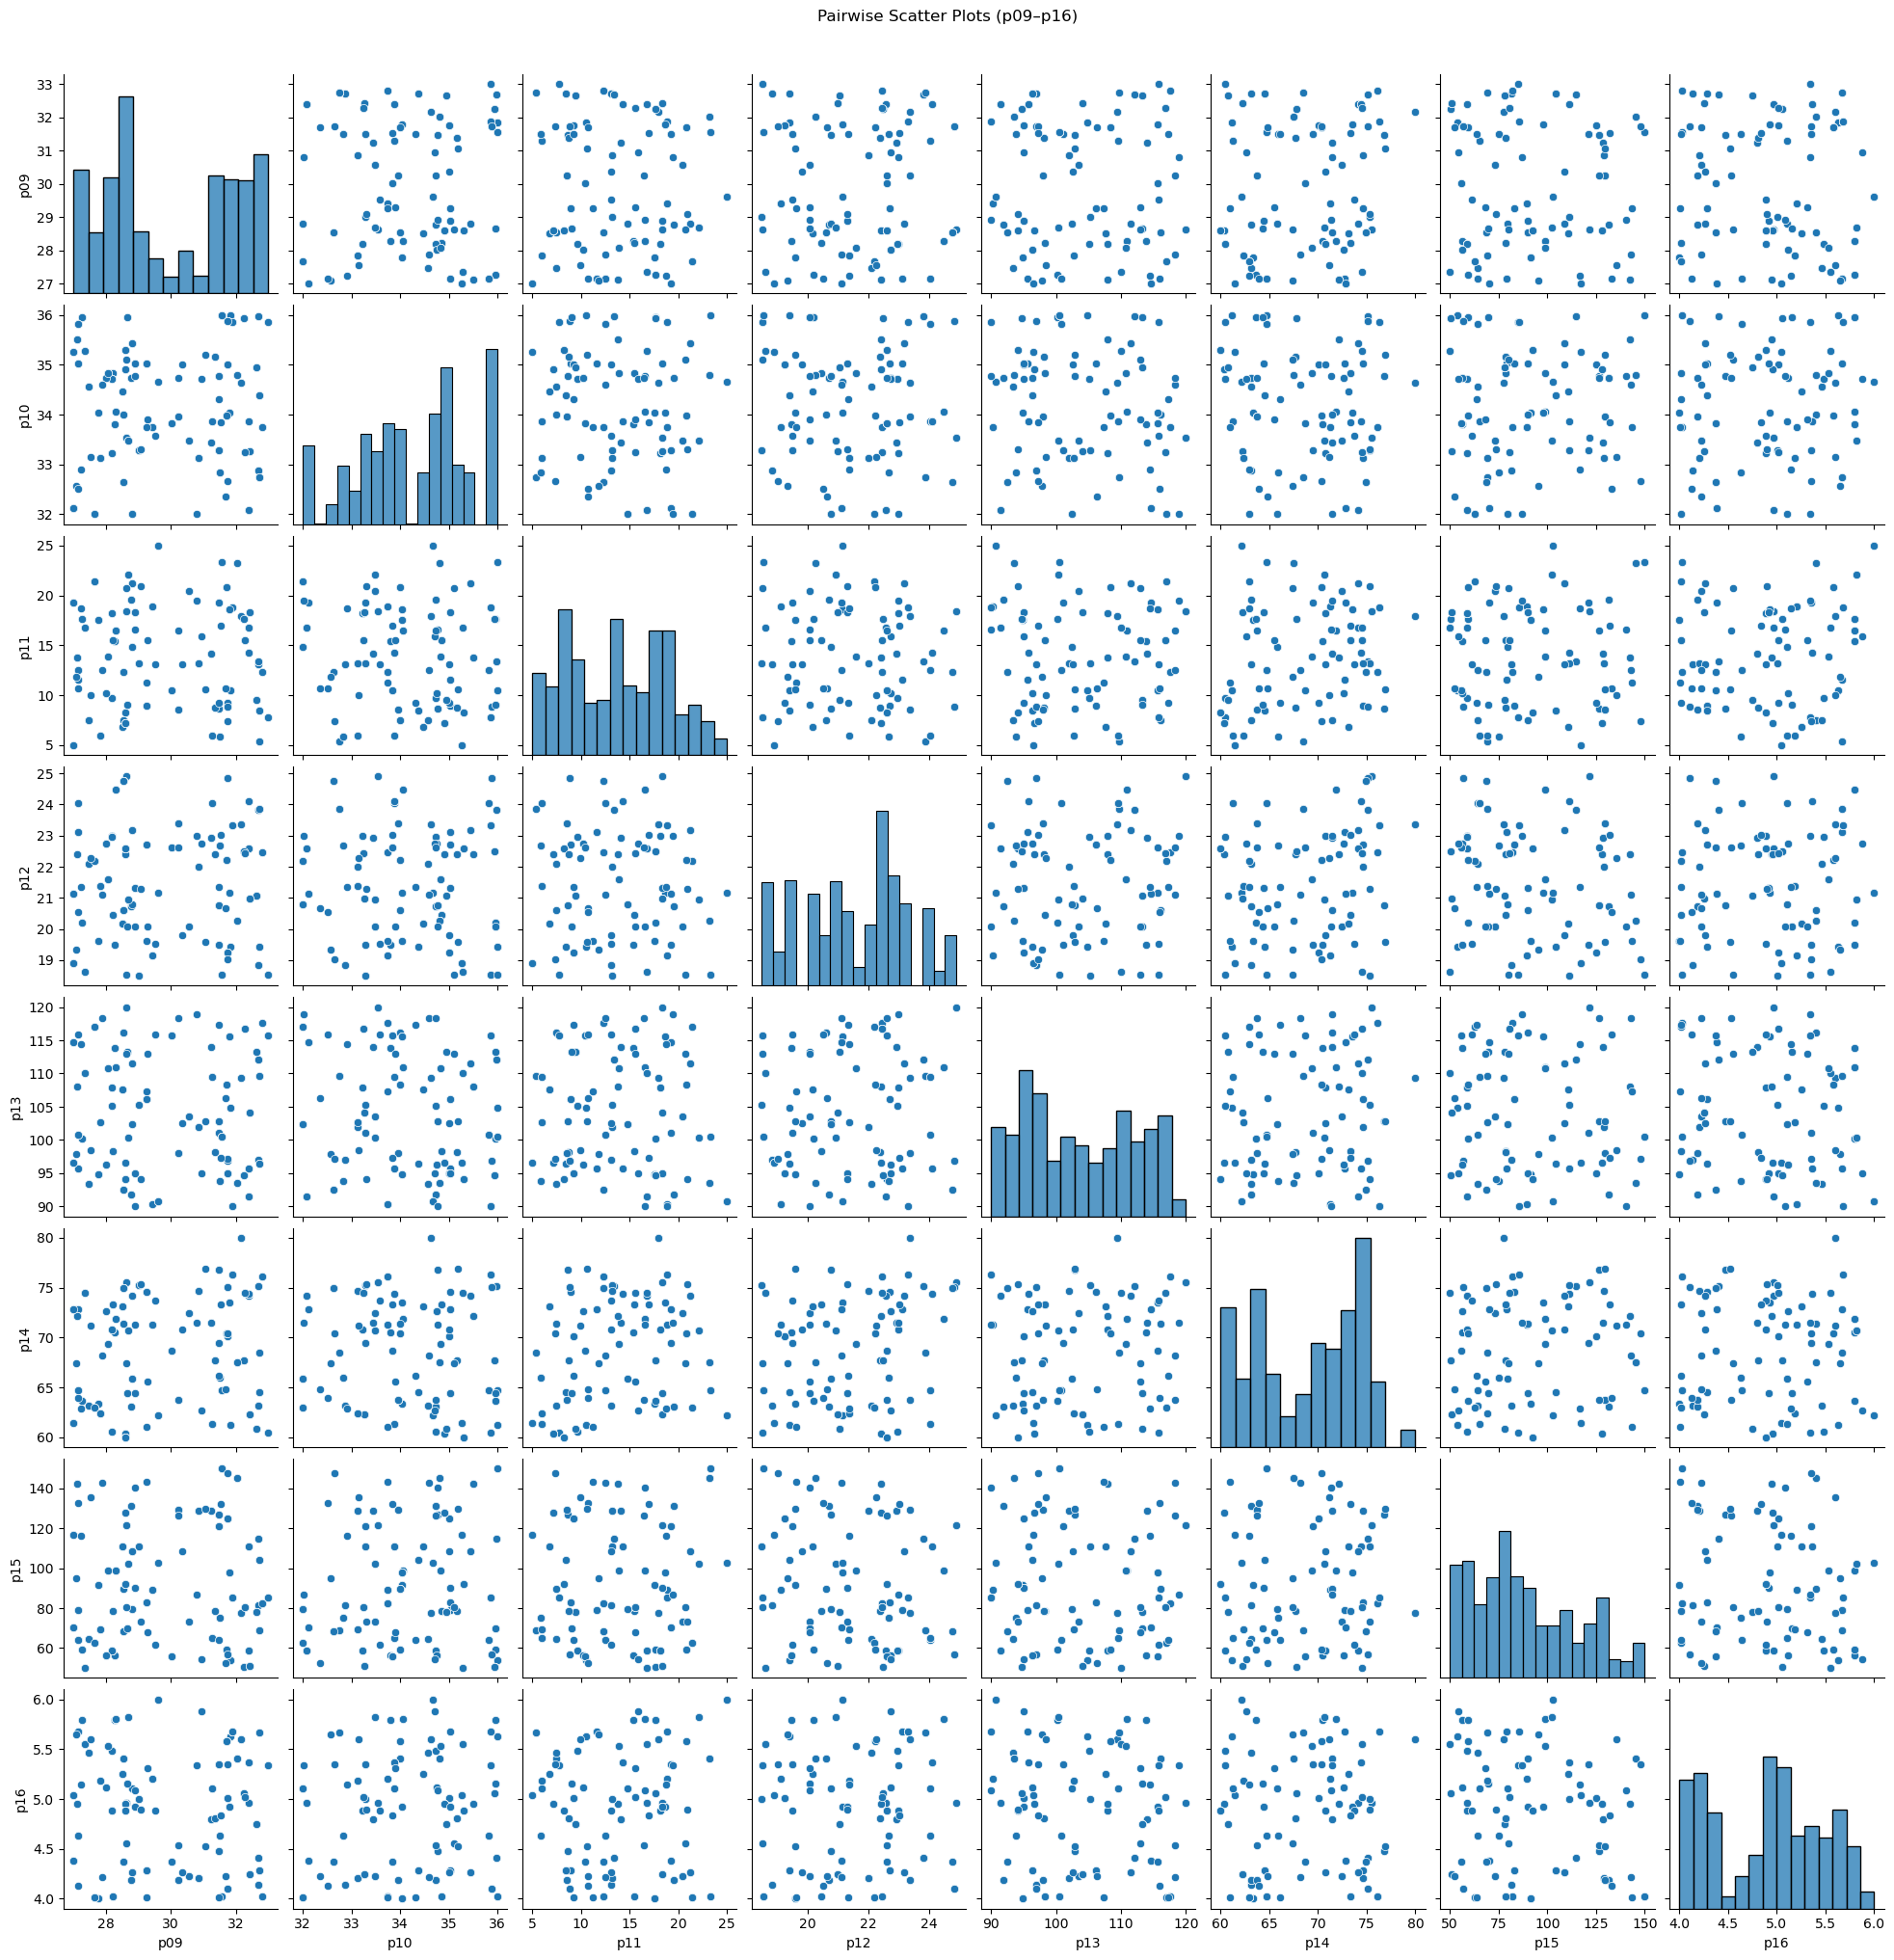

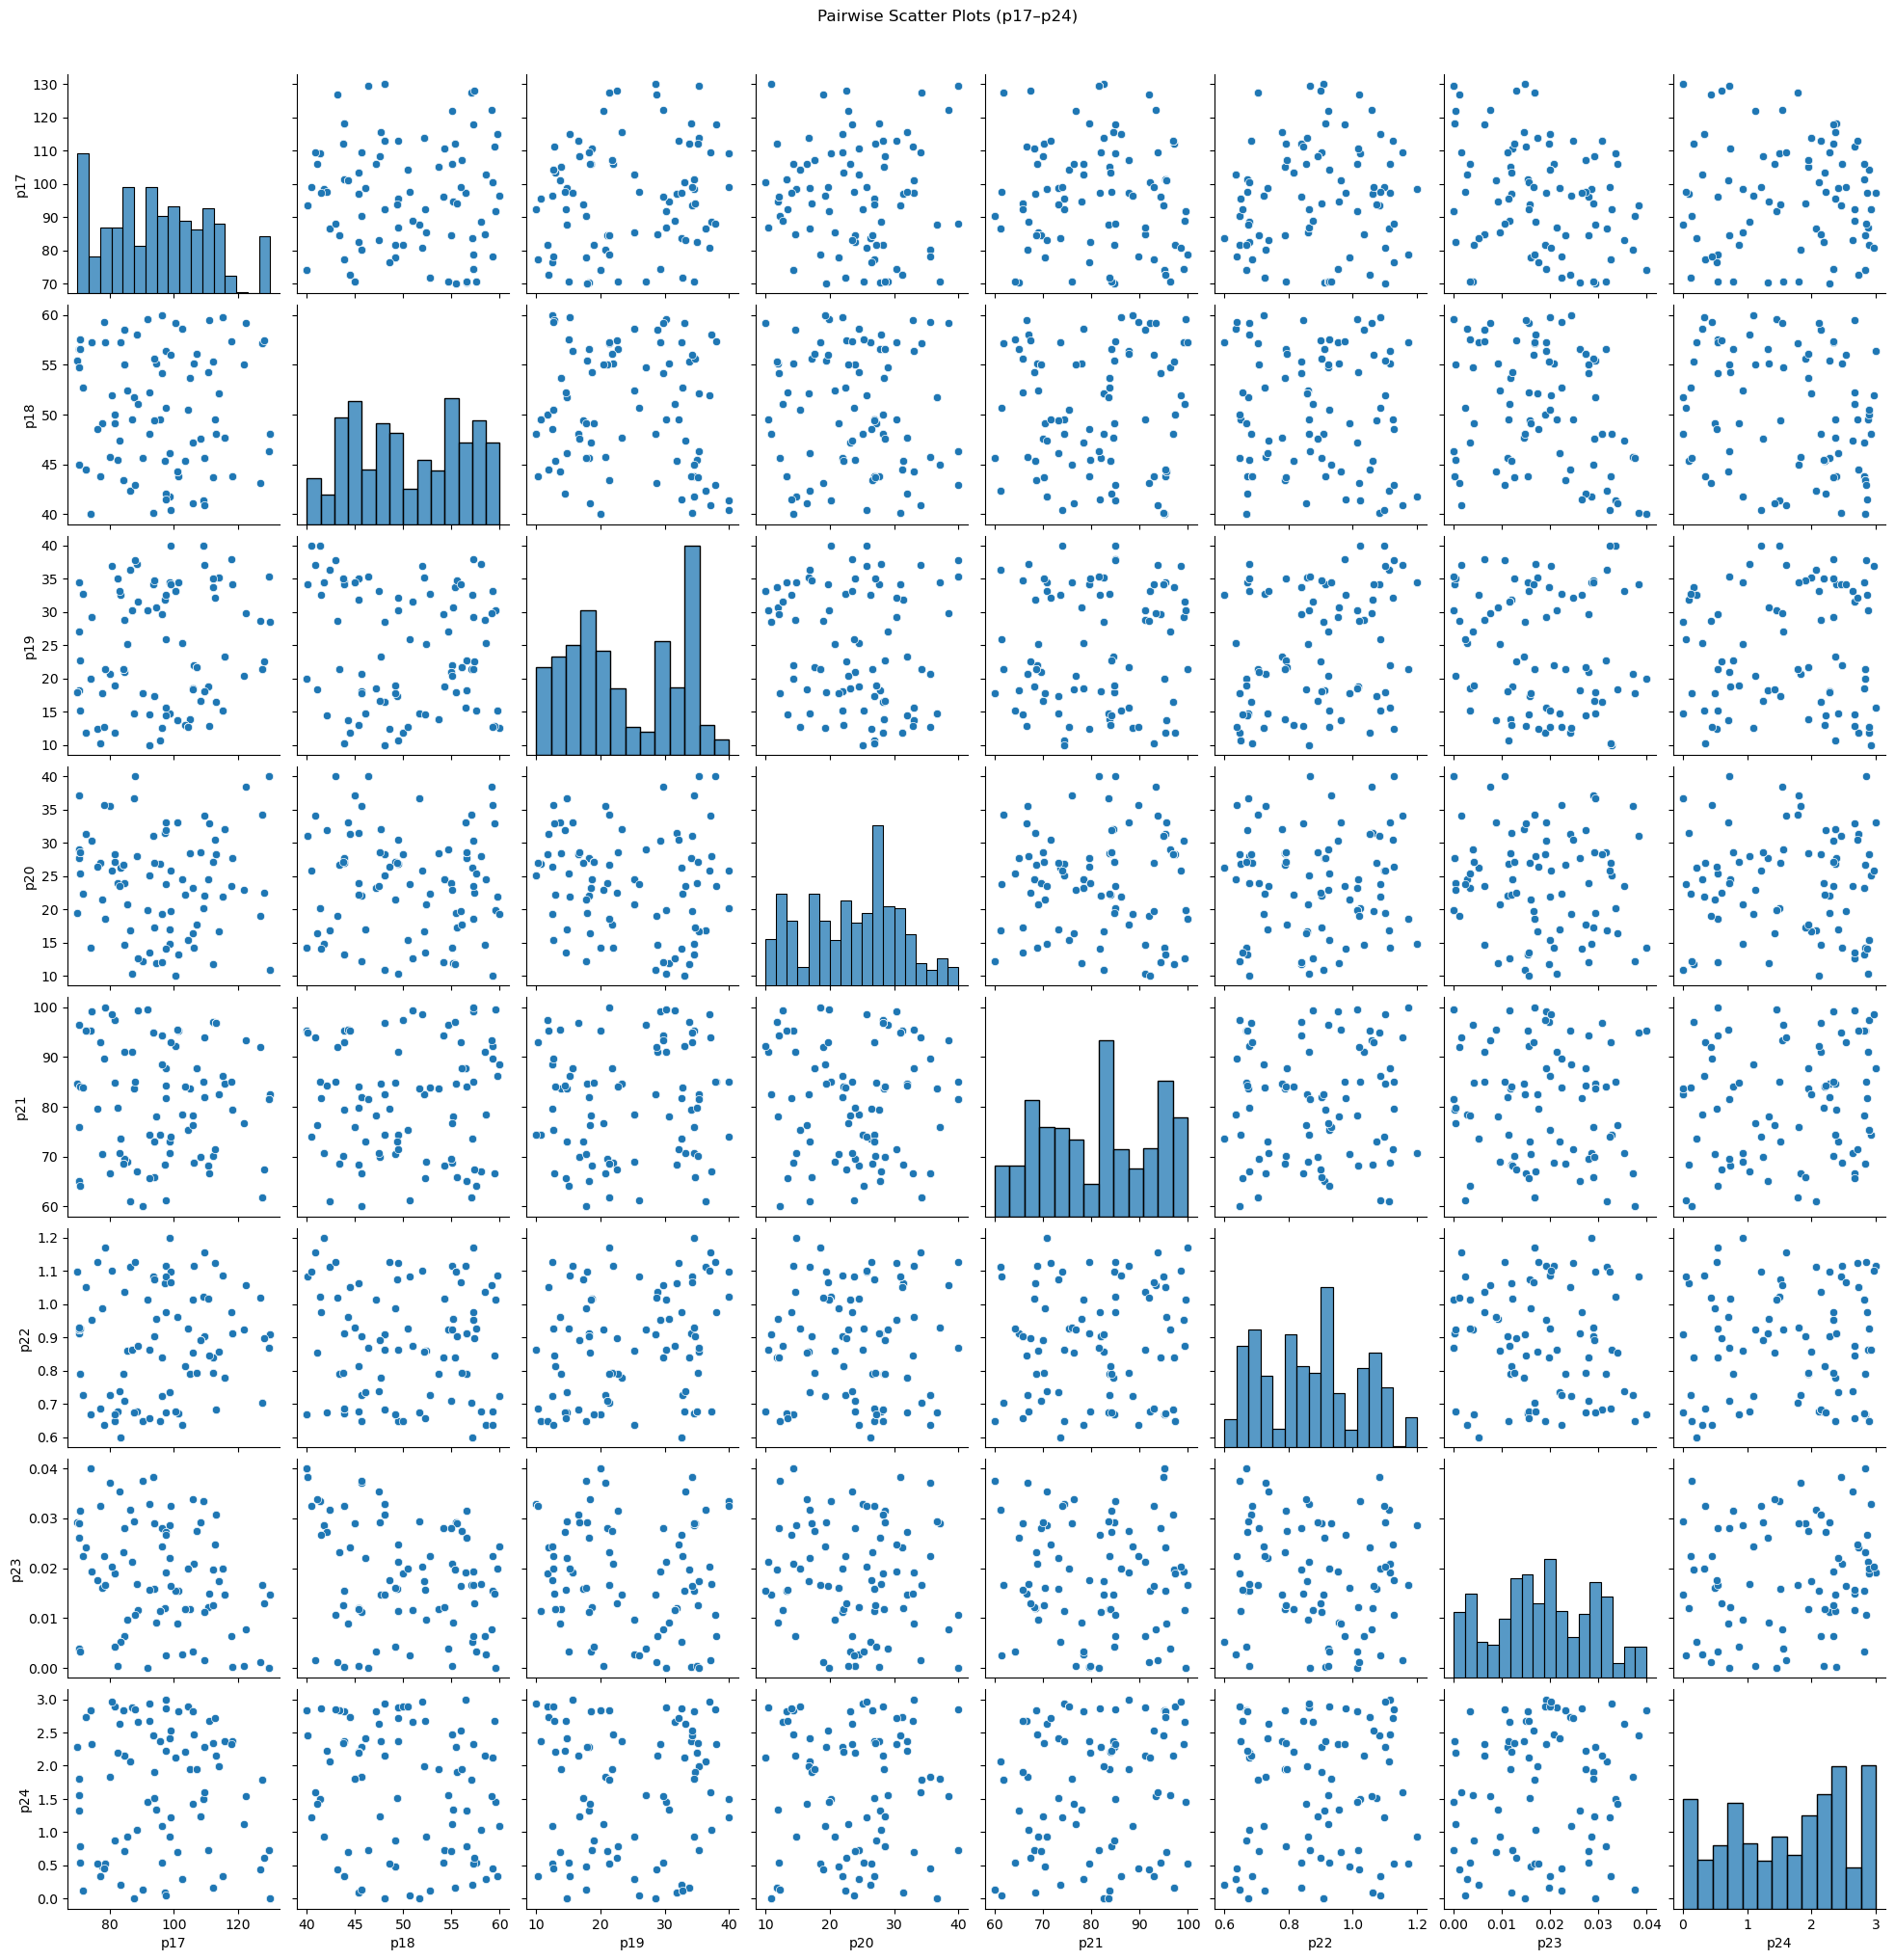

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Loop through groups of 8 columns each
for i in range(0, 24, 8):
    subset_cols = df.columns[i:i+8]
    sns.pairplot(df[subset_cols])
    plt.suptitle(f'Pairwise Scatter Plots ({subset_cols[0]}–{subset_cols[-1]})', y=1.02)
    plt.show()


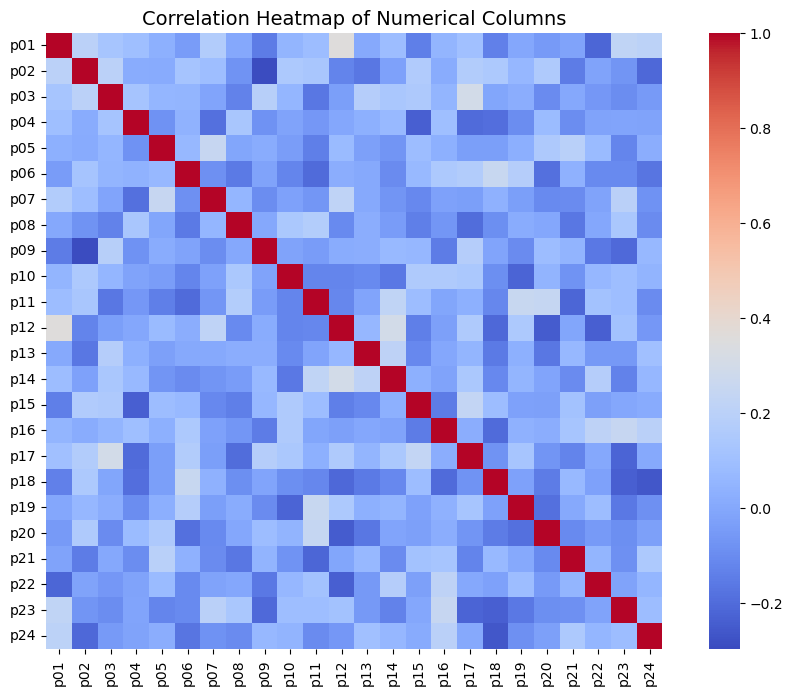

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Select only numeric columns
num_df = df.select_dtypes(include=['number'])

# Compute correlation only on numeric data
corr = num_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', annot=False, square=True)
plt.title('Correlation Heatmap of Numerical Columns', fontsize=14)
plt.show()


# Conclusions based on Pairwise Scatter Plots and Correlation Heatmap

### Observations:

The heatmap shows that most variables are weakly correlated, indicating that each parameter carries largely independent information.

The highest positive correlations are modest (e.g., p01–p12 = 0.36, p12–p14 = 0.30), suggesting mild linear relationships but no strong redundancy.

The negative correlations (e.g., p02–p09 = –0.30, p18–p24 = –0.26) are also weak, implying limited inverse relationships.

The pairwise scatter plots confirm this pattern — points are broadly scattered without tight linear alignment, reinforcing that the variables do not strongly depend on each other.

# Q11 — Handling Missing Values
### Observations from Earlier Analysis

The missing value summary showed that only a small proportion of data was missing across columns.

None of the columns showed systematic missingness (not concentrated in a specific category or group).

# Conclusion

Since missingness is limited and random, we can safely impute rather than drop rows or columns.

For numeric columns, replacing missing values with the median is preferred because: Median is robust to outliers .

For categorical columns, the mode (most frequent value) is the logical imputation since it maintains valid class membership.

In [55]:
# Separate numeric and categorical columns
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c])]

# Impute numeric columns with median
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Impute categorical columns with mode
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Verify
print("Remaining missing values after imputation:")
print(df.isna().sum().sum())


Remaining missing values after imputation:
0


In [56]:
# ================================================================
# Q12. Create a Logistic Regression model using this data. 
# Create the train/test metrics. 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# -------------------------------------------
# Step 1: Encode target and split the dataset
# -------------------------------------------
# Encode the categorical target column "Ailment"
le = LabelEncoder()
df["Ailment"] = le.fit_transform(df["Ailment"])

# Separate features (X) and target (y)
X = df.drop("Ailment", axis=1)
y = df["Ailment"]

# Split into training and test data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------------------------
# Step 2: Standardize numeric features
# -------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------------------------------
# Step 3: Train the Logistic Regression model
# -------------------------------------------
model = LogisticRegression(max_iter=1000, solver='lbfgs')
model.fit(X_train_scaled, y_train)

# -------------------------------------------
# Step 4: Evaluate model performance
# -------------------------------------------
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Function to print metrics for clarity
def print_metrics(y_true, y_pred, dataset_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"\n📊 {dataset_name} Metrics:")
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1-score : {f1:.3f}")

# Print train and test metrics
print_metrics(y_train, y_train_pred, "Train")
print_metrics(y_test, y_test_pred, "Test")

# Confusion Matrix for Test Data
print("\nConfusion Matrix (Test Data):")
print(confusion_matrix(y_test, y_test_pred))



📊 Train Metrics:
Accuracy : 0.994
Precision: 0.994
Recall   : 0.994
F1-score : 0.992

📊 Test Metrics:
Accuracy : 0.994
Precision: 0.994
Recall   : 0.994
F1-score : 0.992

Confusion Matrix (Test Data):
[[125   0   0   0   0   0]
 [  0 108   0   0   0   0]
 [  0   0 111   0   0   0]
 [  2   0   1   1   0   0]
 [  0   0   0   0 102   0]
 [  0   0   0   0   0  25]]


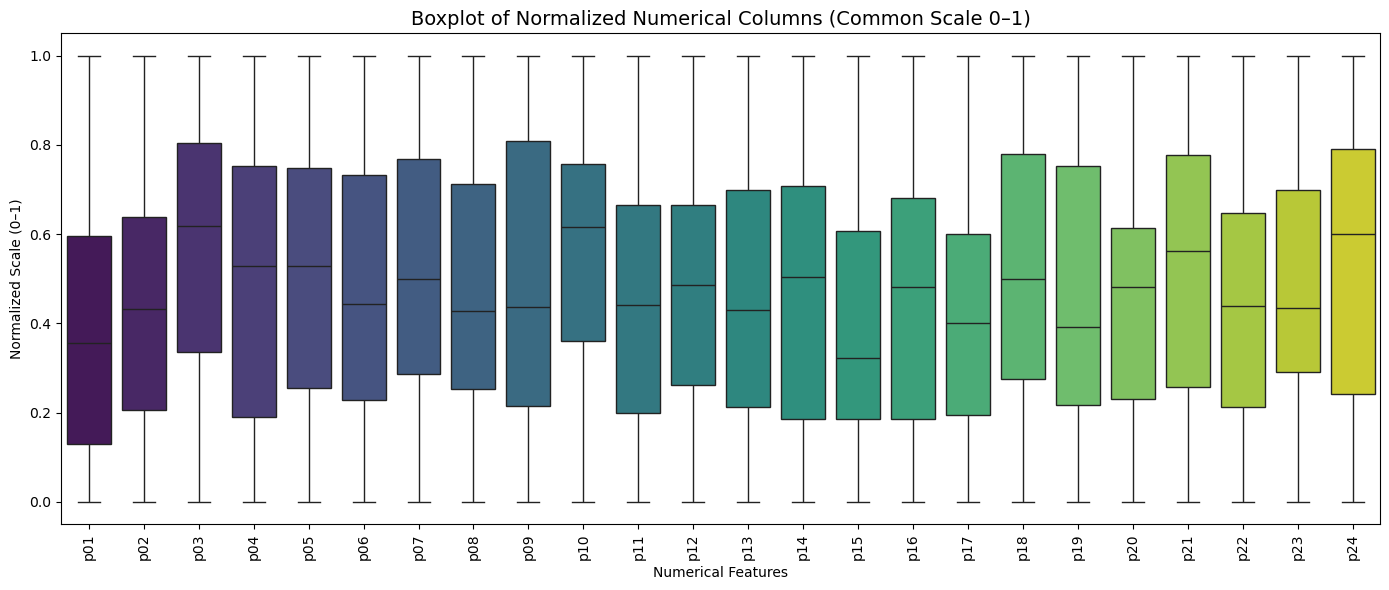

In [57]:
# Q13. Normalize the numerical columns and re-create the common-scale Box-plot

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Identify numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Exclude target column if present
target_col = 'Ailment'
if target_col in numeric_cols:
    numeric_cols = numeric_cols.drop(target_col)

# Normalize only the numeric feature columns
scaler = MinMaxScaler()
df_normalized = df.copy()
df_normalized[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Create boxplot for normalized features
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_normalized[numeric_cols], orient='v', palette='viridis')
plt.title('Boxplot of Normalized Numerical Columns (Common Scale 0–1)', fontsize=14)
plt.ylabel('Normalized Scale (0–1)')
plt.xlabel('Numerical Features')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Interpretation

Only numerical features are included — all categorical or text columns are ignored.

After normalization, every variable lies within the [0, 1] range, making it easy to visually compare distributions.

The plot now reflects true variability of each feature rather than differences in units or magnitude.

Features with narrow boxes are tightly clustered (low variance), while taller boxes or long whiskers show wider dispersion.

In [58]:
# ----------------------------------------
# Q14. Logistic Regression using Normalized Data
# ----------------------------------------

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# 1️ Separate features and target
X = df.drop(columns=["Ailment"])
y = df["Ailment"]

# 2  Normalize only numeric columns
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 3️ Train/test split (same ratio as before)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# 4️ Build and train Logistic Regression model
model_norm = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
model_norm.fit(X_train, y_train)

# 5️ Predictions
y_train_pred = model_norm.predict(X_train)
y_test_pred = model_norm.predict(X_test)

# 6️ Compute metrics
def show_metrics(y_true, y_pred, dataset_name):
    print(f"\n {dataset_name} Metrics:")
    print(f"Accuracy : {accuracy_score(y_true, y_pred):.3f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted'):.3f}")
    print(f"Recall   : {recall_score(y_true, y_pred, average='weighted'):.3f}")
    print(f"F1-score : {f1_score(y_true, y_pred, average='weighted'):.3f}")

show_metrics(y_train, y_train_pred, "Train")
show_metrics(y_test, y_test_pred, "Test")

# 7️ Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (Test Data):")
print(cm)



 Train Metrics:
Accuracy : 0.991
Precision: 0.991
Recall   : 0.991
F1-score : 0.987

 Test Metrics:
Accuracy : 0.992
Precision: 0.983
Recall   : 0.992
F1-score : 0.987

Confusion Matrix (Test Data):
[[125   0   0   0   0   0]
 [  0 108   0   0   0   0]
 [  0   0 111   0   0   0]
 [  2   1   1   0   0   0]
 [  0   0   0   0 102   0]
 [  0   0   0   0   0  25]]


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# conclusion
Normalization did not significantly alter the model’s performance but ensured feature comparability and numerical consistency. The results are consistent and stable, indicating that the data were already well-scaled and linearly separable.